#### Laurent Jutras-Dubé

## The 3-gene models: asymmetric patterns

####   


**1. Pattern formation with the asymmetric 3-gene models**

In this notebook, we perform deterministic simulations of the 3-gene models. We introduce asymmetries in the repression thresholds of the static term, which leads to the formation of an asymmetric spatial pattern of protein expression. See the Methods and Supplement for a description of the models.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patheffects as PathEffects
plt.rcParams.update({'figure.max_open_warning': 0})

####     

**1.1 The ODEs**

In the following code cell, we define functions for the ODEs describing the dynamics of the 3 proteins. We make sure that we can easily modify the parameters of the repression interactions to generate asymmetries in the spatial pattern of protein expression. We specify the values of all parameters later in this notebook. Note that the parameters of the Hill function describing the repression of, say, protein $A$ by protein $B$ in the static term are named `stat_K_BA` and `stat_n_BA`.

In [2]:
def dynamic(conc, param):
    
    A = conc[:,0]
    B = conc[:,1]
    C = conc[:,2]
    
    K_BA = param["dyn_K_BA"]
    K_CB = param["dyn_K_CB"]
    K_AC = param["dyn_K_AC"]
    
    n_BA = param["dyn_n_BA"]
    n_CB = param["dyn_n_CB"]
    n_AC = param["dyn_n_AC"]
       
    dA = 1./(1.+(B/K_BA)**n_BA)
    dB = 1./(1.+(C/K_CB)**n_CB)
    dC = 1./(1.+(A/K_AC)**n_AC)
    
    return np.array([dA, dB, dC]).transpose()



def static(conc, param):
    
    A = conc[:,0]
    B = conc[:,1]
    C = conc[:,2]
    
    K_BA = param["stat_K_BA"]
    K_CB = param["stat_K_CB"]
    K_AC = param["stat_K_AC"]
    K_CA = param["stat_K_CA"]
    K_AB = param["stat_K_AB"]
    K_BC = param["stat_K_BC"]
    
    n_BA = param["stat_n_BA"]
    n_CB = param["stat_n_CB"]
    n_AC = param["stat_n_AC"]
    n_CA = param["stat_n_CA"]
    n_AB = param["stat_n_AB"]
    n_BC = param["stat_n_BC"]
       
    dA = 1./(1.+(B/K_BA)**n_BA) /(1.+(C/K_CA)**n_CA)
    dB = 1./(1.+(C/K_CB)**n_CB) /(1.+(A/K_AB)**n_AB)
    dC = 1./(1.+(A/K_AC)**n_AC) /(1.+(B/K_BC)**n_BC)
    
    return np.array([dA, dB, dC]).transpose()



def dconc(conc, g, param):
    
    g = np.array([g, g, g]).transpose()
    ng = param["ng"]
    
    return g**ng *dynamic(conc, param) +(1.-g)**ng *static(conc, param) -conc

####     

**1.2 The morphogen gradient**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed, we make $t^*(x)$ a linear function of $x$, via the `positions` vector and the `v` parameter. In other words, we model a gradient of $g$ with a fixed steepness that moves in the posterior direction at a constant rate. We generate a kymograph showing the spatio-temporal profiles of $g$ later in this notebook.

In [3]:
def compute_g(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The integration scheme**

We use the Euler integration scheme to perform the integration of the ODEs. The `integrate` function requires two inputs: the initial concentration of the 3 genes at all spatial positions, and the dictionary of parameters. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasing this parameter can help reduce the size of the three output matrices, `results`, `g_gradient` and `times_plot`. These matrices respectively contain the concentration of the 3 genes at all positions for every time point, the spatio-temporal distribution of parameter $g$ and the array of times.

In [4]:
def integrate(init_conc, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)

    conc = init_conc
    results = [conc]
    g = compute_g(0., param)
    g_gradient = [g]
    times_plot = [0.]
    
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]

    
    # Perform the integration
    for t in times[1:]:
        
        conc = conc +dconc(conc, g, param)*dt
        conc[conc < 0.] = 0.
        
        g = compute_g(t, param)
           
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(conc)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

####  

**1.4 The kymograph plots**

We visualize the results with a kymograph where the $x$ axis is time and the $y$ axis is the position of the cell along the tissue. We represent the concentration of the genes with a purple to blue to white color scheme, where white (blue and purple, resp.) means that gene $A$ ($B$ and $C$, resp.) is predominant in that cell at that time. A cell that contains a mix of the three genes appears grey on the kymograph.

We plot lines representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely $0.5$ and $0.2$. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

Finally, we also define a function that plots the spatio-temporal profile of parameter $g$.

In [5]:
def compute_x(g, t, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s -x_osc +v*t



def compute_t(g, x, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return (x_osc +x -np.log(g)/s)/v
    

    
def plot_kymograph(results, g_gradient, times_plot, title, param):
    
    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()
    
    # Kymograph
    norm = colors.Normalize(vmin=0., vmax=1.)
    ax.imshow(results[:,:,1].transpose(), norm=norm, cmap='PuBu', aspect='auto')
    kymo = ax.imshow(results[:,:,2].transpose(), norm=norm, cmap='BuPu', aspect='auto', alpha=0.5)
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
    cb.ax.tick_params(labelsize=24)
    cb.ax.set_yticklabels(['A', 'B', 'C'])
    
    # Lines of constant g
    ax.plot(param["n_cells"]*compute_x(1., times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.55, param)/param["dt"]-800., param["n_cells"]*0.55, 'g=1', color='k', rotation=-72, fontsize=24)
    ax.text(compute_t(0.5, 0.55, param)/param["dt"]-50., param["n_cells"]*0.55, 'g=0.5', rotation=-72, color='k', fontsize=24)
    ax.text(compute_t(0.2, 0.55, param)/param["dt"]-50., param["n_cells"]*0.55, 'g=0.2', rotation=-72, color='k', fontsize=24)
    
    # Other plot options
    ax.set_title(title, fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()
    
    
    
def plot_g_gradient(g_gradient, times_plot, param):

    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()

    # Kymograph
    norm = colors.Normalize(vmin=0., vmax=1.)
    kymo = ax.imshow(g_gradient.transpose(), norm=norm, cmap='Greys', aspect='auto')
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
    cb.ax.tick_params(labelsize=24)
    
    # Lines of constant g
    ax.plot(param["n_cells"]*compute_x(1., times_plot, param), color='w', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.55, param)/param["dt"]-800., param["n_cells"]*0.55, 'g=1', color='w', rotation=-72, fontsize=28)
    ax.text(compute_t(0.5, 0.55, param)/param["dt"]-50., param["n_cells"]*0.55, 'g=0.5', rotation=-72, color='k', fontsize=28)
    ax.text(compute_t(0.2, 0.55, param)/param["dt"]-50., param["n_cells"]*0.55, 'g=0.2', rotation=-72, color='k', fontsize=28)
    
    # Other plot options
    ax.set_title('$g(x,t)$', fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()

####  

**1.5 The dynamics of pattern formation in Models 1 and 2**

We define all the required parameters for the ODEs, the morphogen gradient and the integration. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. In Model 1, we set parameter `ng` to 2, while in Model 2, we set `ng` to 1.

In [6]:
param ={
    
    # Integration parameters
    "total_t"              : 60.,
    "dt"                   : 0.01,
    "n_steps_keep_results" : 1,
    "n_cells"              : 500,

    # ODE parameters
    "ng" : 2,
    
    "dyn_K_BA" : 0.4,
    "dyn_K_CB" : 0.4,
    "dyn_K_AC" : 0.4,
    
    "dyn_n_BA" : 5,
    "dyn_n_CB" : 5,
    "dyn_n_AC" : 5,
    
    "stat_K_BA" : 0.4,
    "stat_K_CB" : 0.4,
    "stat_K_AC" : 0.4,
    "stat_K_CA" : 0.4,
    "stat_K_AB" : 0.4,
    "stat_K_BC" : 0.4,
    
    "stat_n_BA" : 5,
    "stat_n_CB" : 5,
    "stat_n_AC" : 5,
    "stat_n_CA" : 5,
    "stat_n_AB" : 5,
    "stat_n_BC" : 5,
    
    # Morphogen gradient parameters
    "x_osc" : 0.2,
    "s"     : 1.,
    "v"     : 0.05
}



init_conc = np.zeros((param["n_cells"], 3))
init_conc[:,0] = 0.75

####      

**1.5.1 Weak asymmetry**

We first introduce an asymmetry in the static term by decreasing the thresholds of repression of protein $A$ by proteins $B$ and $C$. We study the robustness of the patterns formed by Models 1 and 2 to decreases in the steepness of the spatial profile of parameter $g$, which can be interpreted as a morphogen concentration. Note that we model embryo elongation by moving the morphogen gradient in the posterior direction at a constant speed. Therefore, decreasing the spatial steepness of the morphogen is equivalent to decreasing the time-scale of morphogen decay in single cells.

In [7]:
param["stat_K_AB"] = 0.4
param["stat_K_AC"] = 0.4
param["stat_K_BA"] = 0.36
param["stat_K_BC"] = 0.4
param["stat_K_CA"] = 0.36
param["stat_K_CB"] = 0.4


# Steep gradient for g
param["s"] = 2.5

param["ng"] = 2
results_asym1_steep_m1, g_gradient_asym1_steep_m1, times_plot_asym1_steep_m1 = integrate(init_conc, param)

param["ng"] = 1
results_asym1_steep_m2, g_gradient_asym1_steep_m2, times_plot_asym1_steep_m2 = integrate(init_conc, param)



# Shallow gradient for g
param["s"] = 1.

param["ng"] = 2
results_asym1_shallow_m1, g_gradient_asym1_shallow_m1, times_plot_asym1_shallow_m1 = integrate(init_conc, param)

param["ng"] = 1
results_asym1_shallow_m2, g_gradient_asym1_shallow_m2, times_plot_asym1_shallow_m2 = integrate(init_conc, param)

####     

In the following code cell, we plot the results for Models 1 and 2 with a steep profile of parameter $g$.

<IPython.core.display.Javascript object>


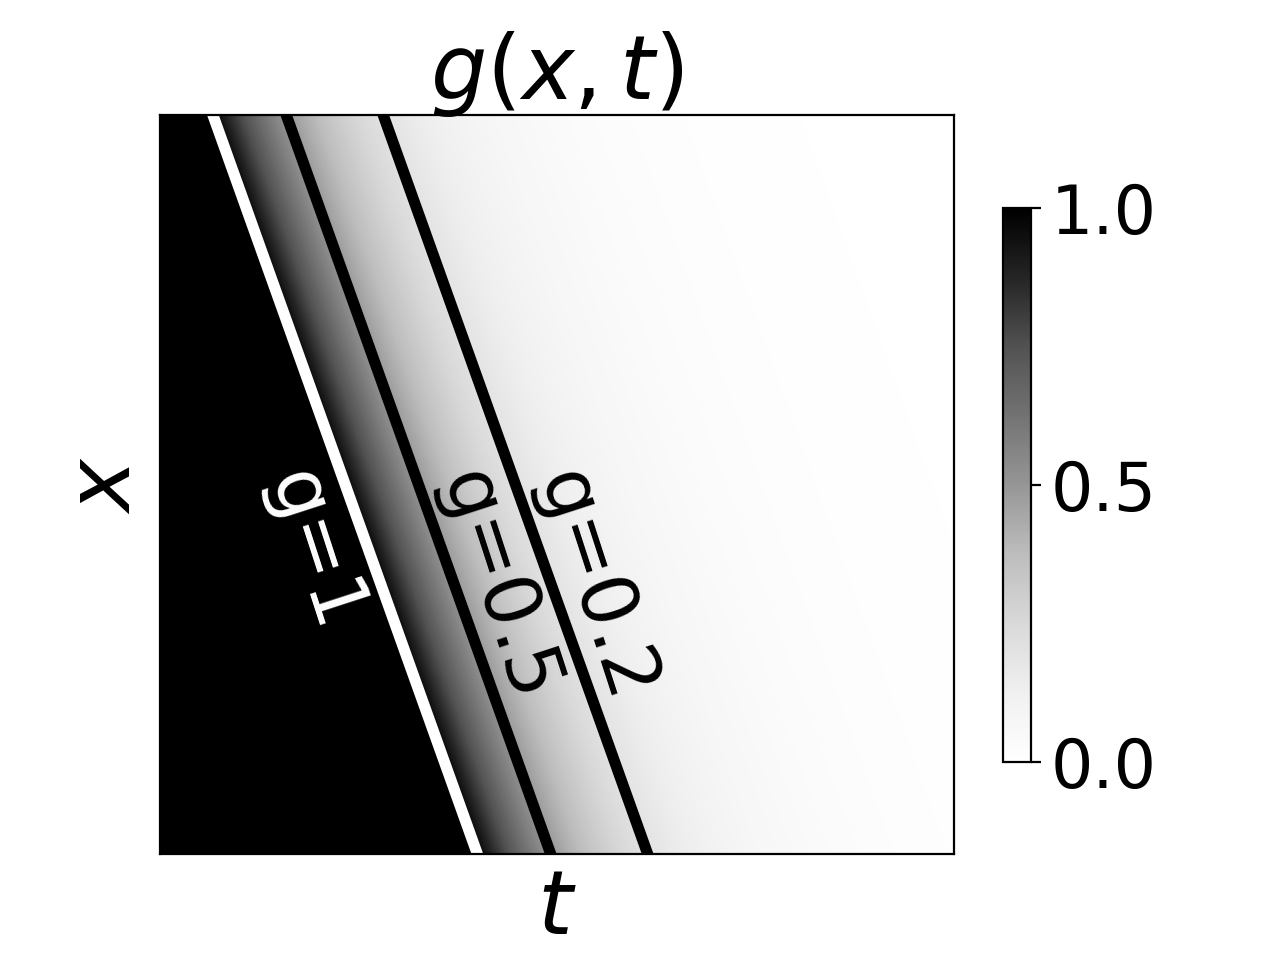

<IPython.core.display.Javascript object>


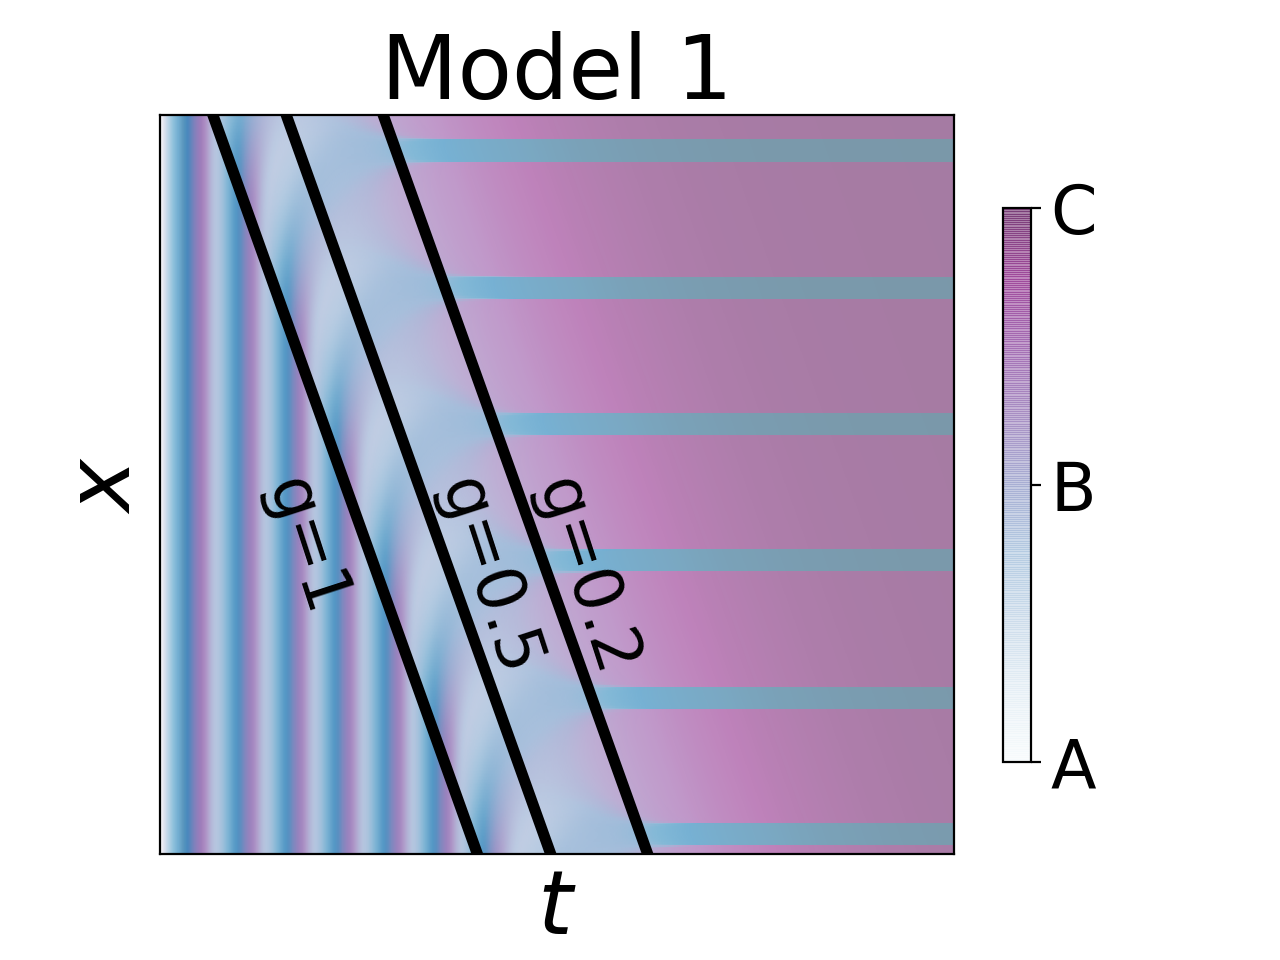

<IPython.core.display.Javascript object>


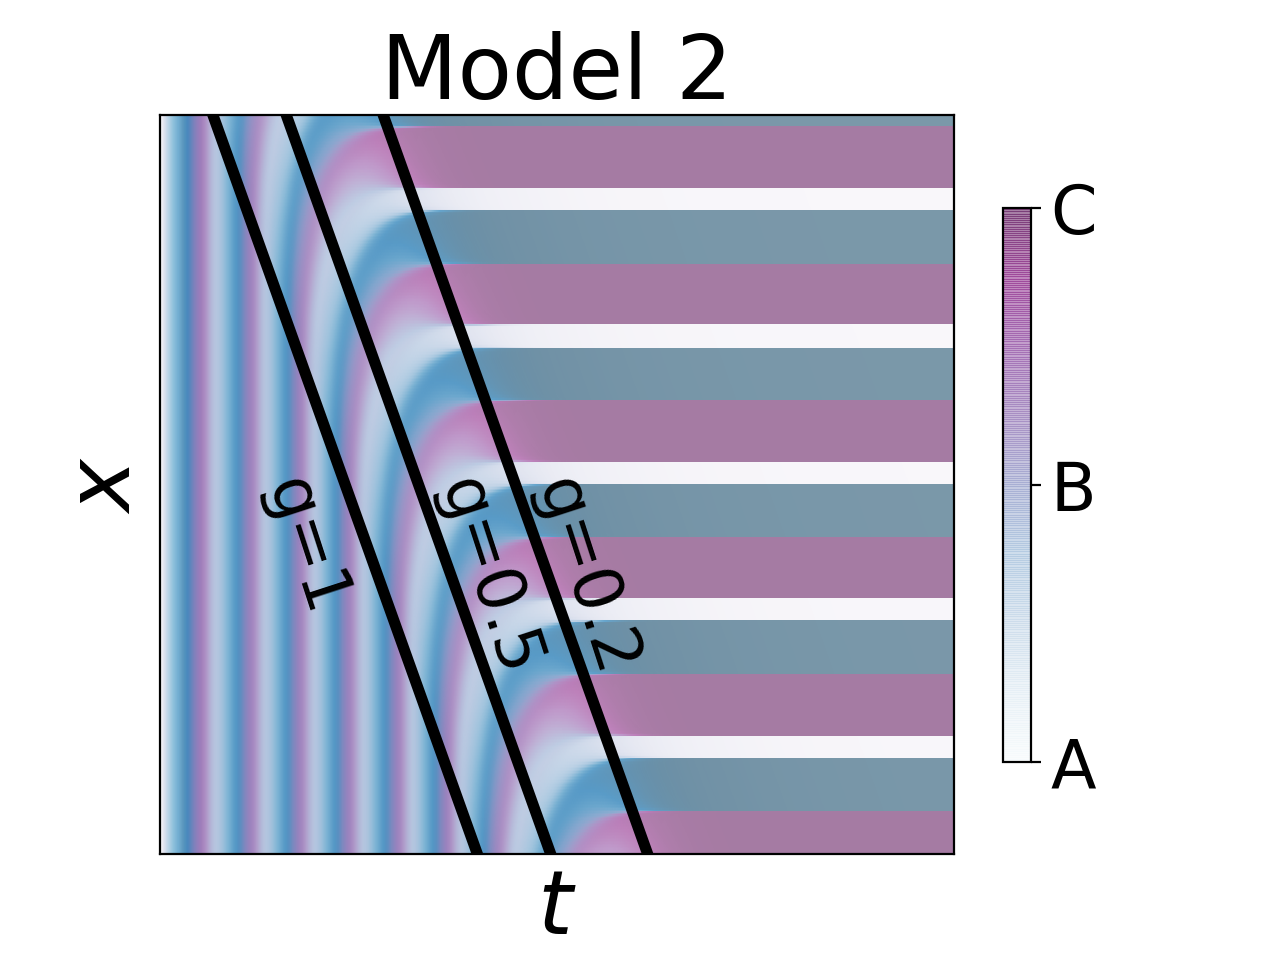

In [8]:
param["s"] = 2.5

plot_g_gradient(g_gradient_asym1_steep_m1, times_plot_asym1_steep_m1, param)
plot_kymograph(results_asym1_steep_m1, g_gradient_asym1_steep_m1, times_plot_asym1_steep_m1, 'Model 1', param)
plot_kymograph(results_asym1_steep_m2, g_gradient_asym1_steep_m2, times_plot_asym1_steep_m2, 'Model 2', param)

####     

In the following code cell, we plot the results for Models 1 and 2 with a shallow profile of parameter $g$.

<IPython.core.display.Javascript object>


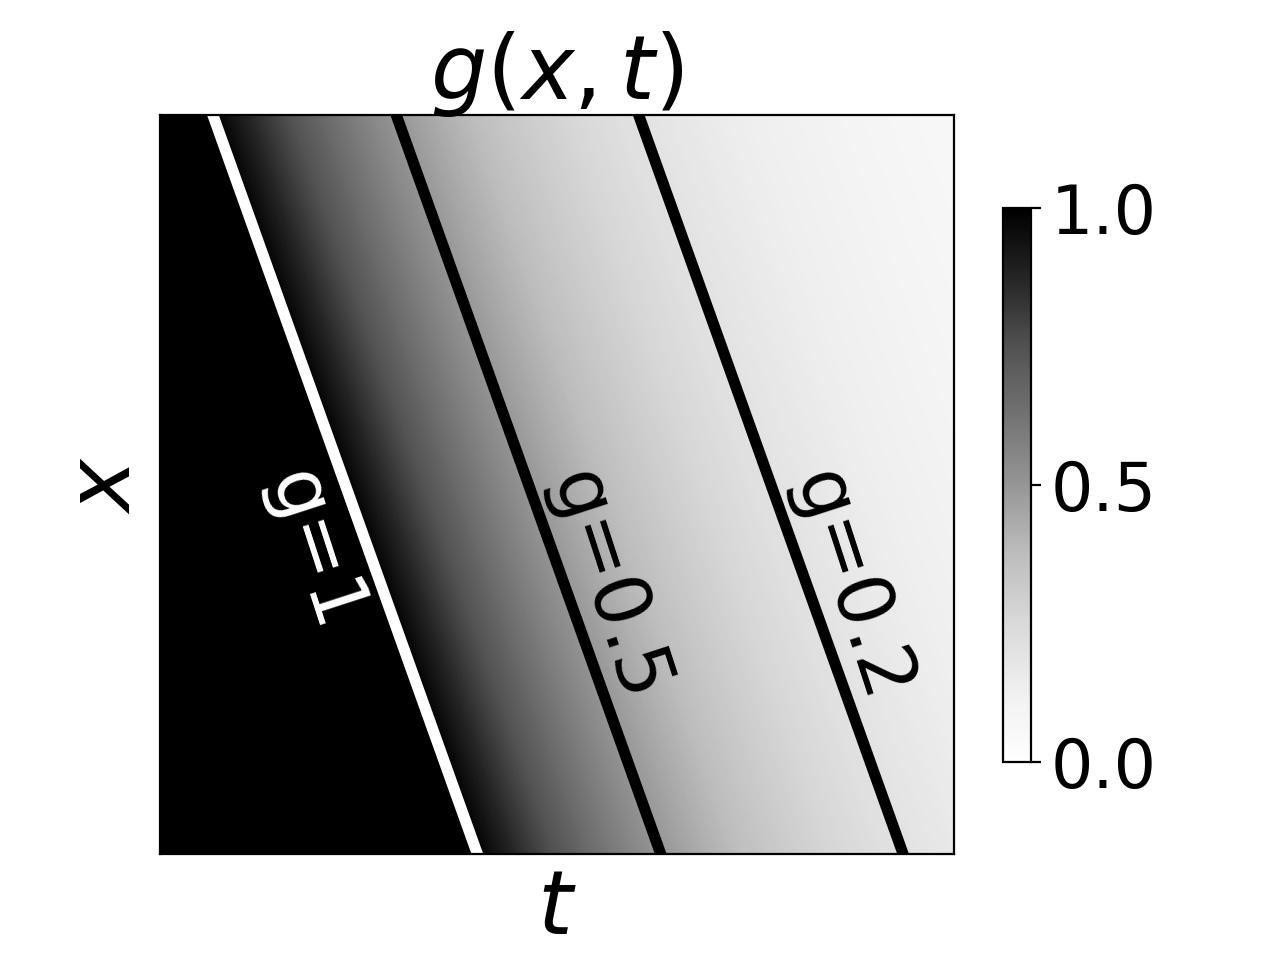

<IPython.core.display.Javascript object>


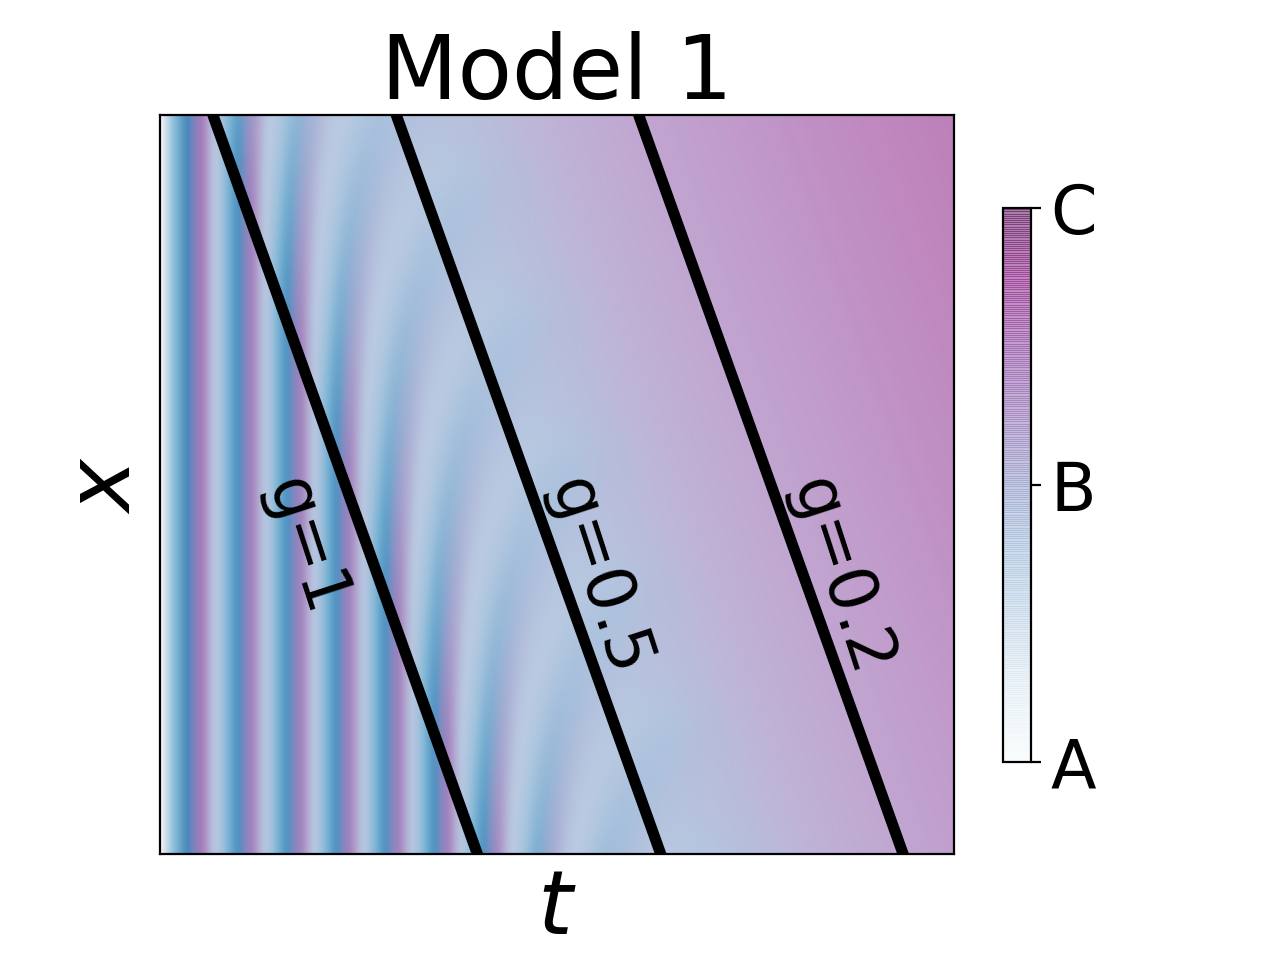

<IPython.core.display.Javascript object>


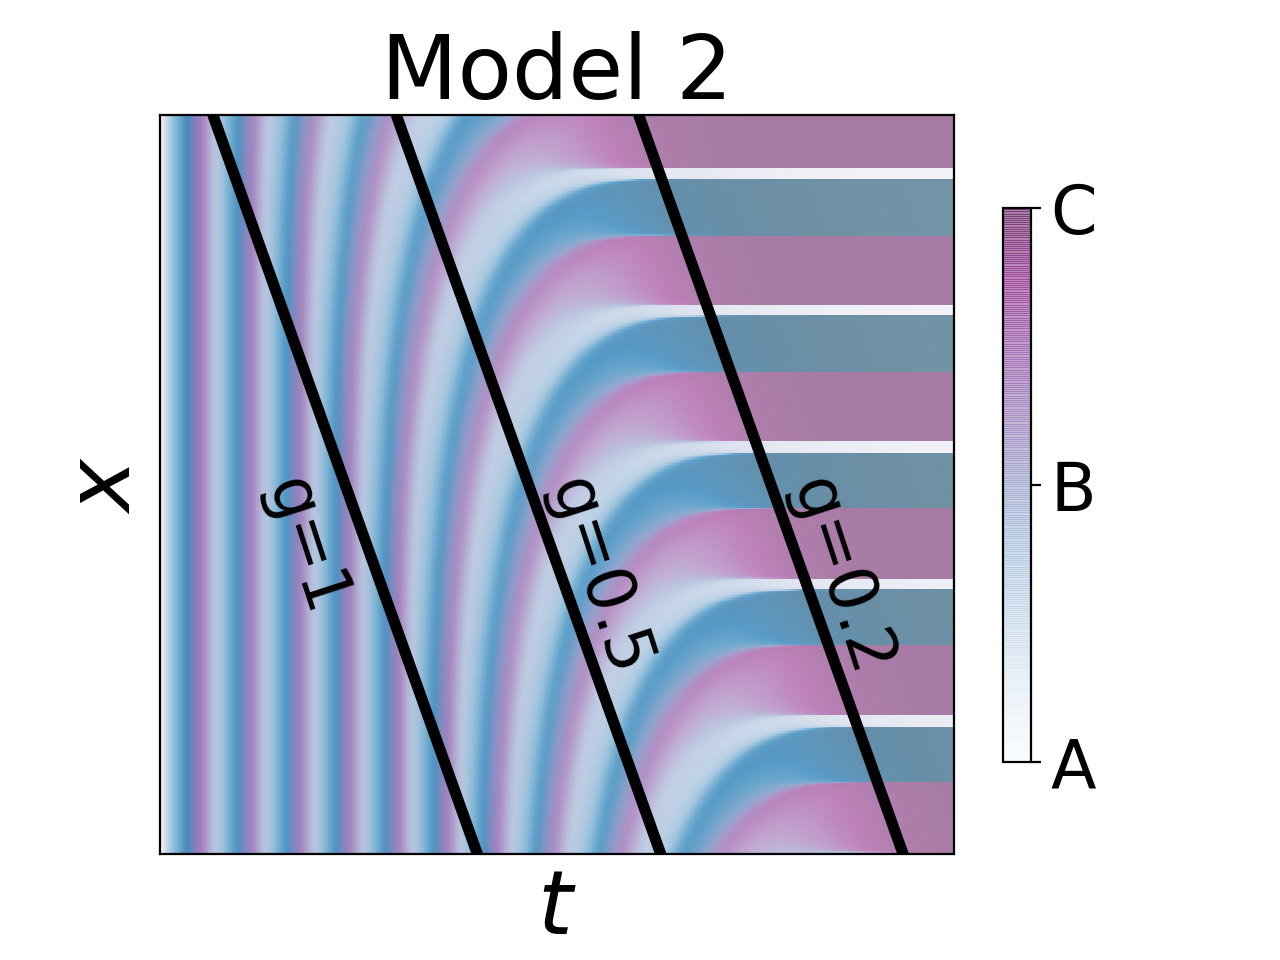

In [9]:
param["s"] = 1.

plot_g_gradient(g_gradient_asym1_shallow_m1, times_plot_asym1_shallow_m1, param)
plot_kymograph(results_asym1_shallow_m1, g_gradient_asym1_shallow_m1, times_plot_asym1_shallow_m1, 'Model 1', param)
plot_kymograph(results_asym1_shallow_m2, g_gradient_asym1_shallow_m2, times_plot_asym1_shallow_m2, 'Model 2', param)

####      

**1.5.2 Strong asymmetry**

We now introduce a strong asymmetry by further decreasing the thresholds of repression of protein $A$ by proteins $B$ and $C$. We also decrease the thresholds of repression of protein $B$ by proteins $A$ and $C$. Again, we study the robustness of the patterns formed by Models 1 and 2 to decreases in the temporal decay of parameter $g$.

In [10]:
param["stat_K_AB"] = 0.36
param["stat_K_AC"] = 0.4
param["stat_K_BA"] = 0.32
param["stat_K_BC"] = 0.4
param["stat_K_CA"] = 0.32
param["stat_K_CB"] = 0.36


# Steep gradient for g
param["s"] = 2.5

param["ng"] = 2
results_asym2_steep_m1, g_gradient_asym2_steep_m1, times_plot_asym2_steep_m1 = integrate(init_conc, param)

param["ng"] = 1
results_asym2_steep_m2, g_gradient_asym2_steep_m2, times_plot_asym2_steep_m2 = integrate(init_conc, param)



# Shallow gradient for g
param["s"] = 1.

param["ng"] = 2
results_asym2_shallow_m1, g_gradient_asym2_shallow_m1, times_plot_asym2_shallow_m1 = integrate(init_conc, param)

param["ng"] = 1
results_asym2_shallow_m2, g_gradient_asym2_shallow_m2, times_plot_asym2_shallow_m2 = integrate(init_conc, param)

<IPython.core.display.Javascript object>


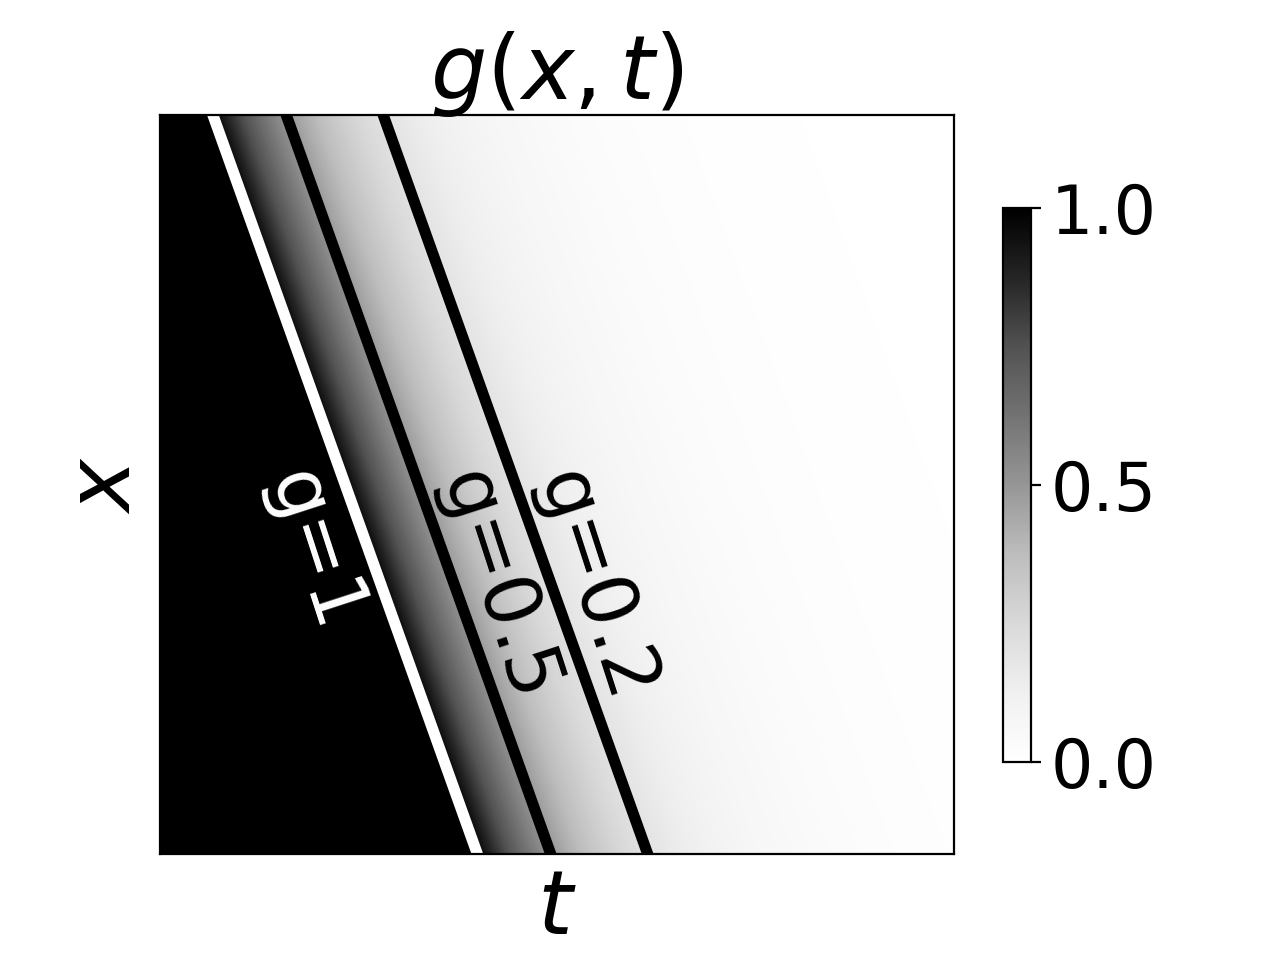

<IPython.core.display.Javascript object>


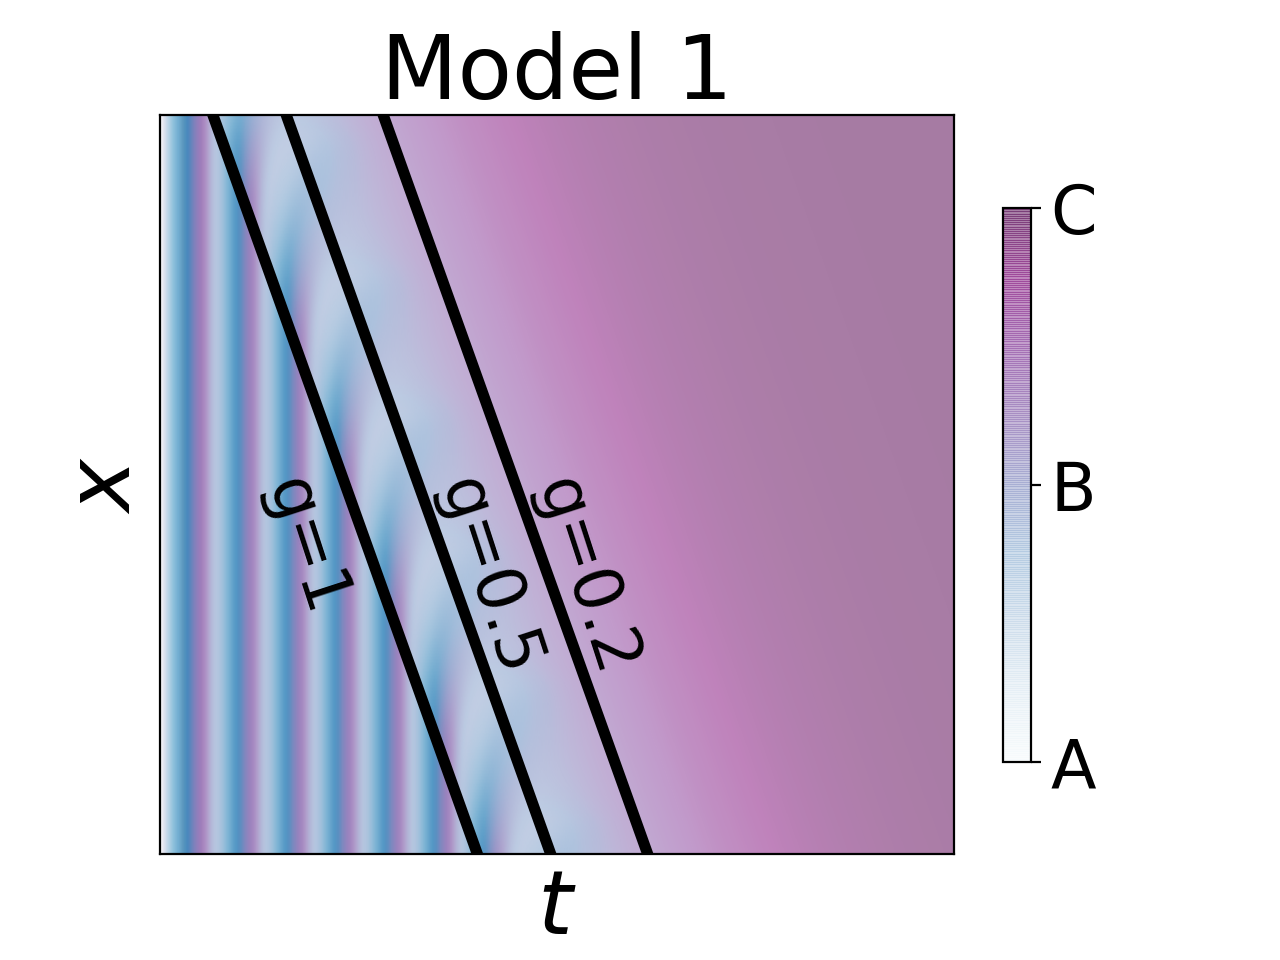

<IPython.core.display.Javascript object>


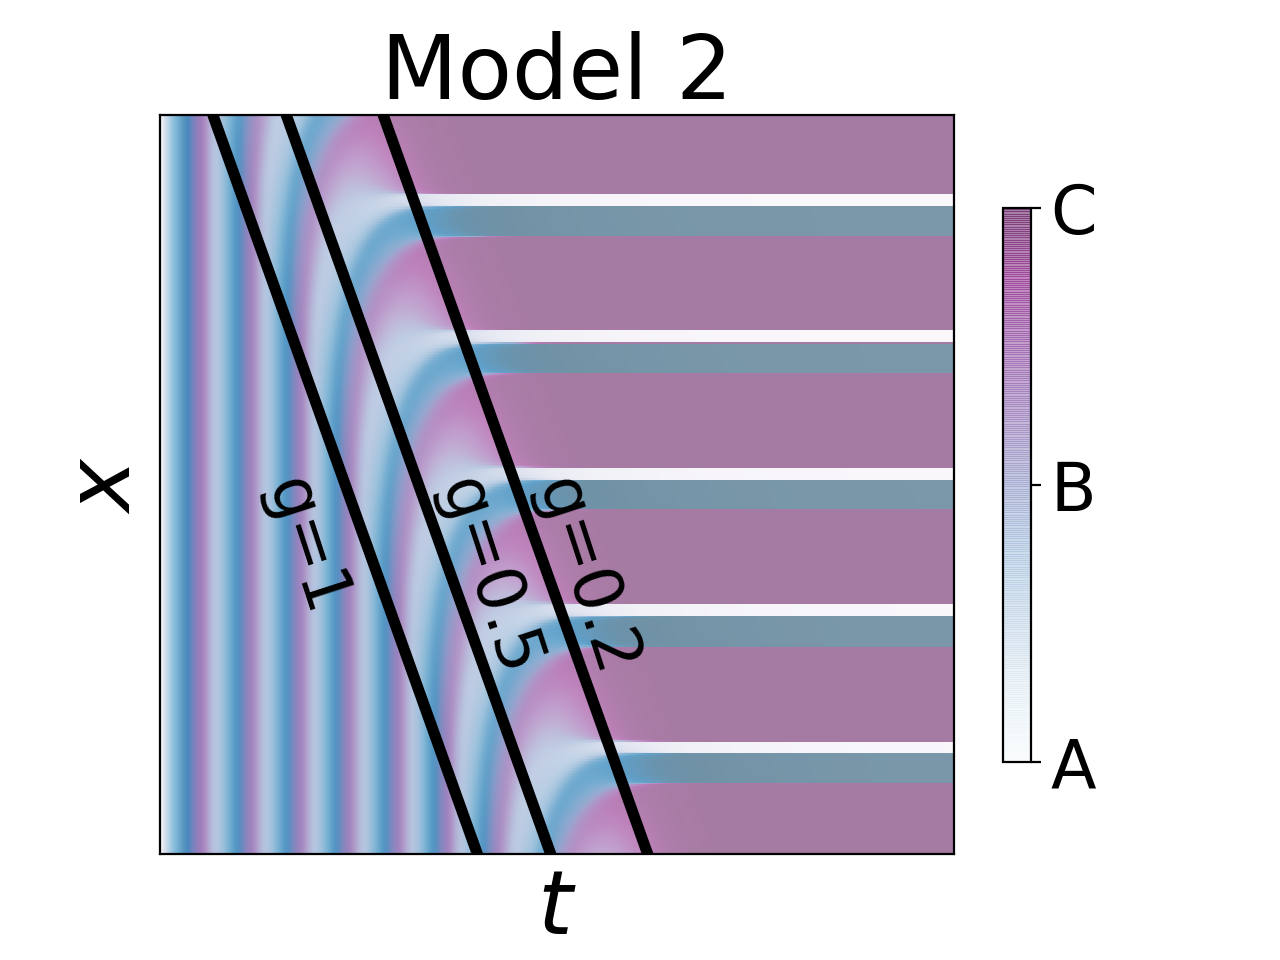

In [11]:
param["s"] = 2.5

plot_g_gradient(g_gradient_asym2_steep_m1, times_plot_asym2_steep_m1, param)
plot_kymograph(results_asym2_steep_m1, g_gradient_asym2_steep_m1, times_plot_asym2_steep_m1, 'Model 1', param)
plot_kymograph(results_asym2_steep_m2, g_gradient_asym2_steep_m2, times_plot_asym2_steep_m2, 'Model 2', param)

<IPython.core.display.Javascript object>


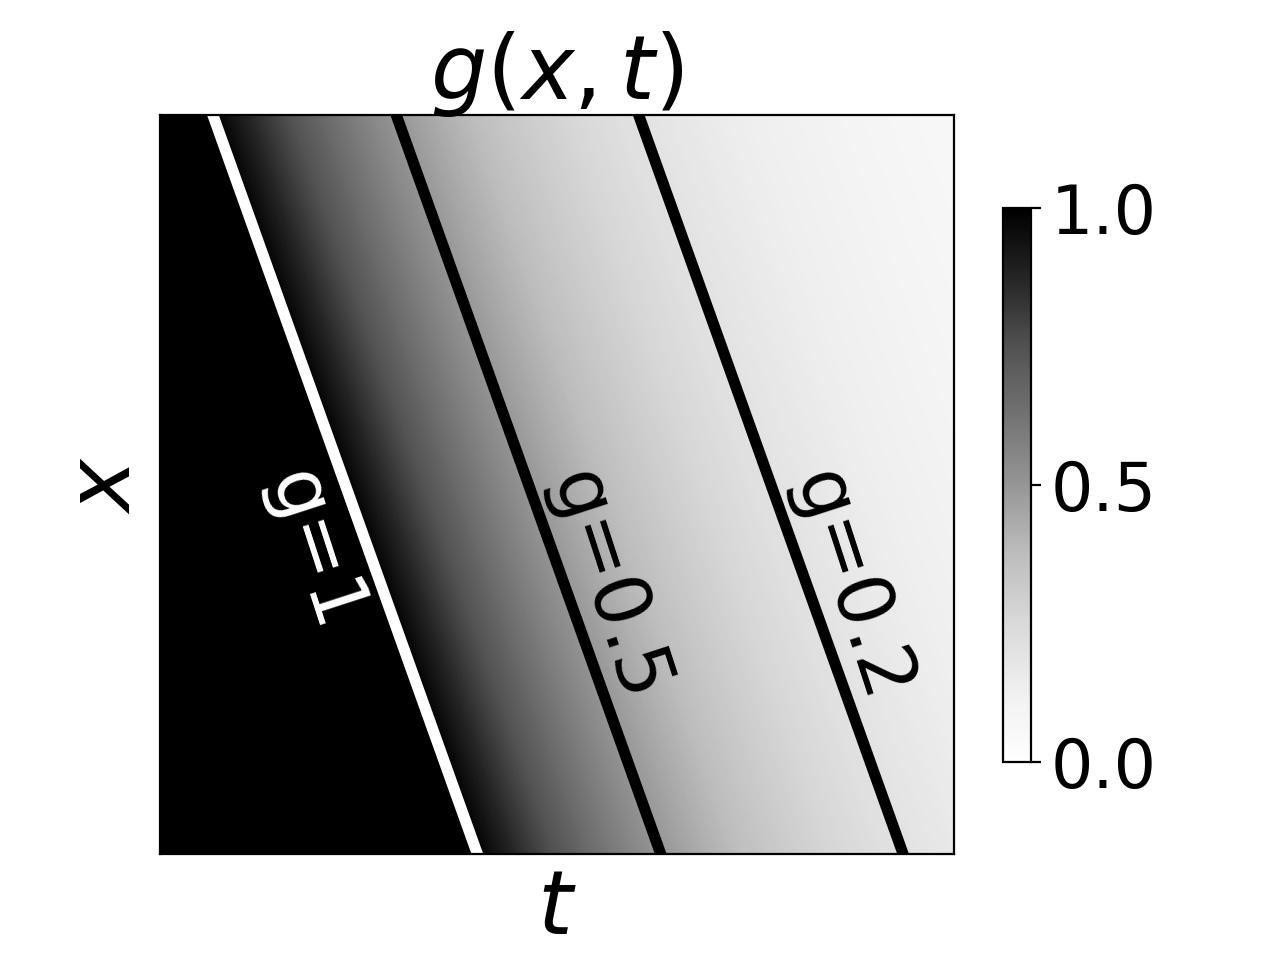

<IPython.core.display.Javascript object>


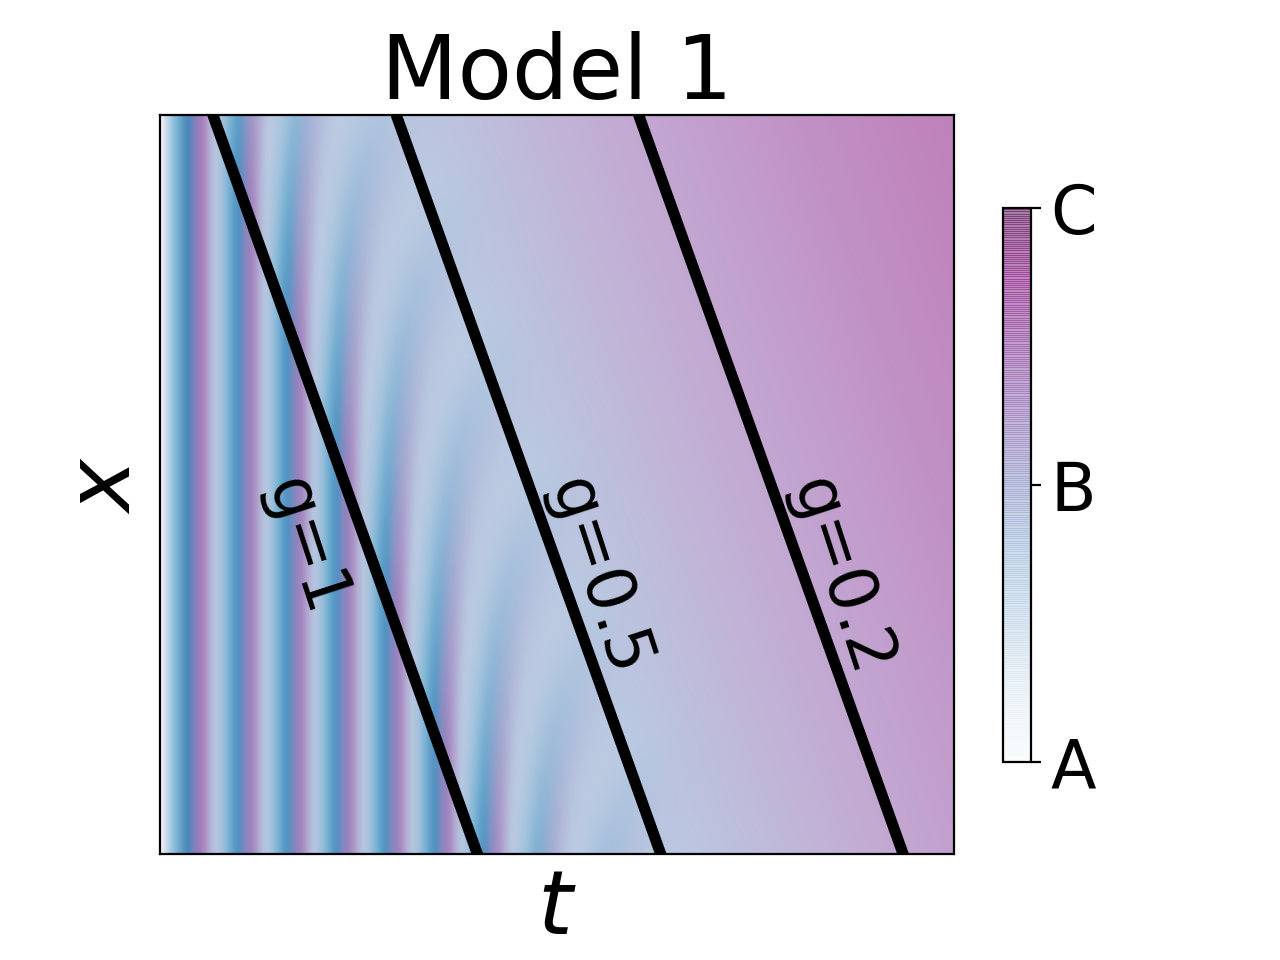

<IPython.core.display.Javascript object>


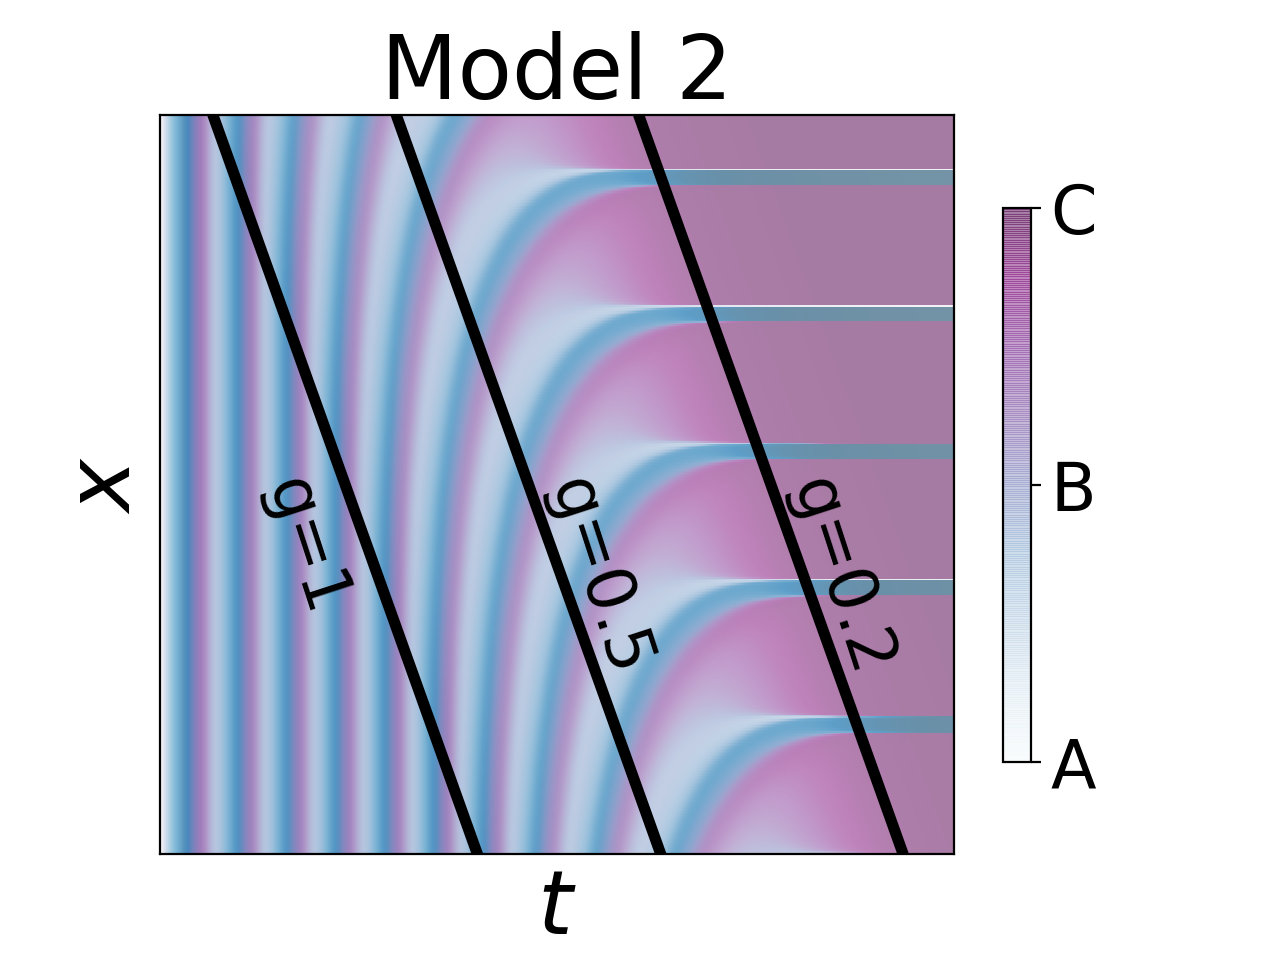

In [12]:
param["s"] = 1.

plot_g_gradient(g_gradient_asym2_shallow_m1, times_plot_asym2_shallow_m1, param)
plot_kymograph(results_asym2_shallow_m1, g_gradient_asym2_shallow_m1, times_plot_asym2_shallow_m1, 'Model 1', param)
plot_kymograph(results_asym2_shallow_m2, g_gradient_asym2_shallow_m2, times_plot_asym2_shallow_m2, 'Model 2', param)

####      

**1.5.3 Random asymmetry**

We now generate a random asymmetry by choosing randomly the strengths of the repression interactions of the static term. We pick the repression strengths from a Gaussian distribution of mean $0.4$ and standard deviation $0.04$.

In [13]:
np.random.seed(78665433)
random_K_asym2 = np.random.normal(loc=0.4, scale=0.04, size=(6,))

param["stat_K_AB"] = random_K_asym2[0]
param["stat_K_AC"] = random_K_asym2[1]
param["stat_K_BA"] = random_K_asym2[2]
param["stat_K_BC"] = random_K_asym2[3]
param["stat_K_CA"] = random_K_asym2[4]
param["stat_K_CB"] = random_K_asym2[5]


# Steep gradient for g
param["s"] = 2.5

param["ng"] = 2
results_asym3_steep_m1, g_gradient_asym3_steep_m1, times_plot_asym3_steep_m1 = integrate(init_conc, param)

param["ng"] = 1
results_asym3_steep_m2, g_gradient_asym3_steep_m2, times_plot_asym3_steep_m2 = integrate(init_conc, param)



# Shallow gradient for g
param["s"] = 1.

param["ng"] = 2
results_asym3_shallow_m1, g_gradient_asym3_shallow_m1, times_plot_asym3_shallow_m1 = integrate(init_conc, param)

param["ng"] = 1
results_asym3_shallow_m2, g_gradient_asym3_shallow_m2, times_plot_asym3_shallow_m2 = integrate(init_conc, param)

<IPython.core.display.Javascript object>


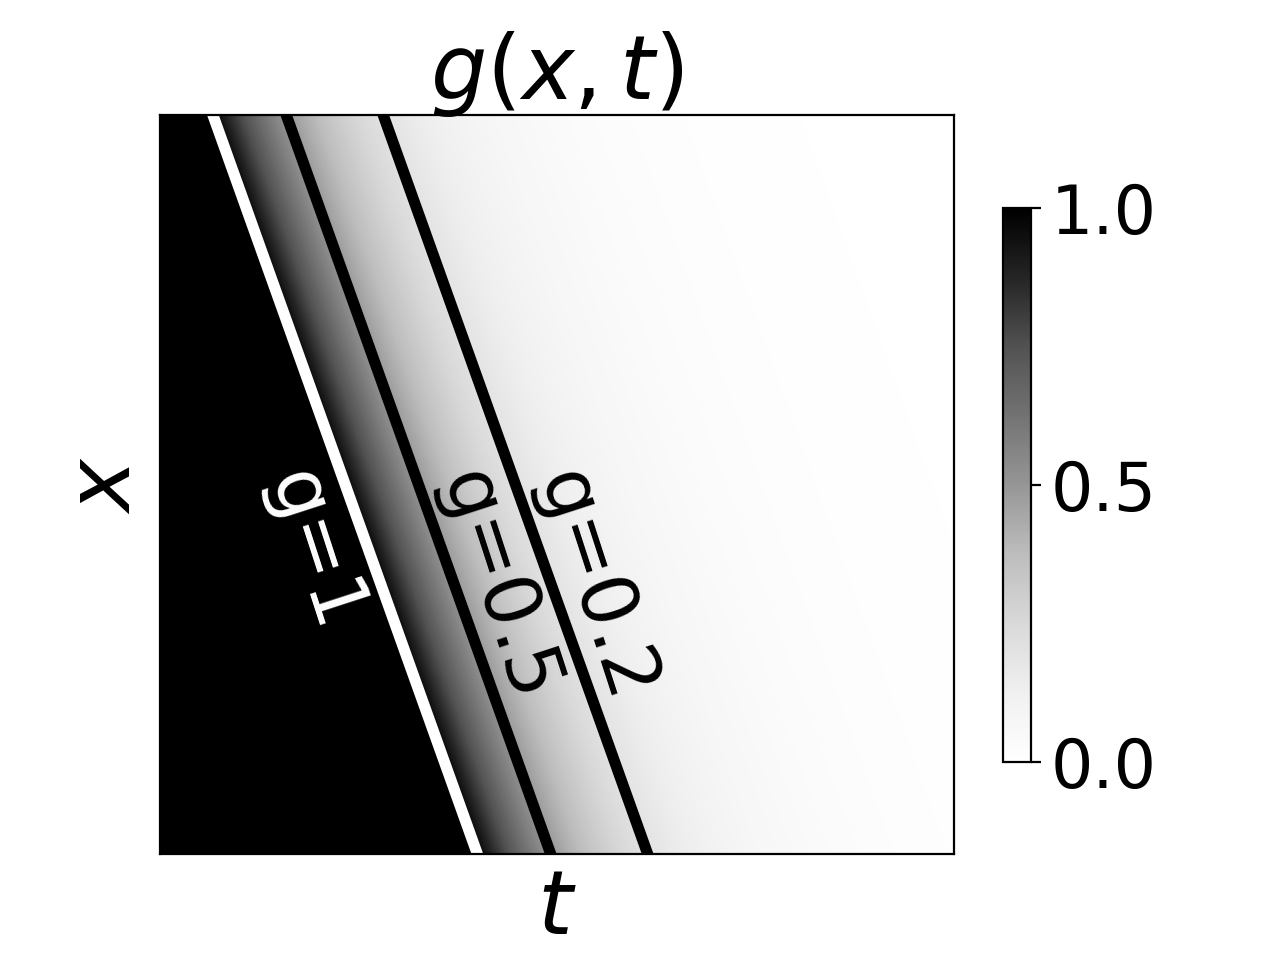

<IPython.core.display.Javascript object>


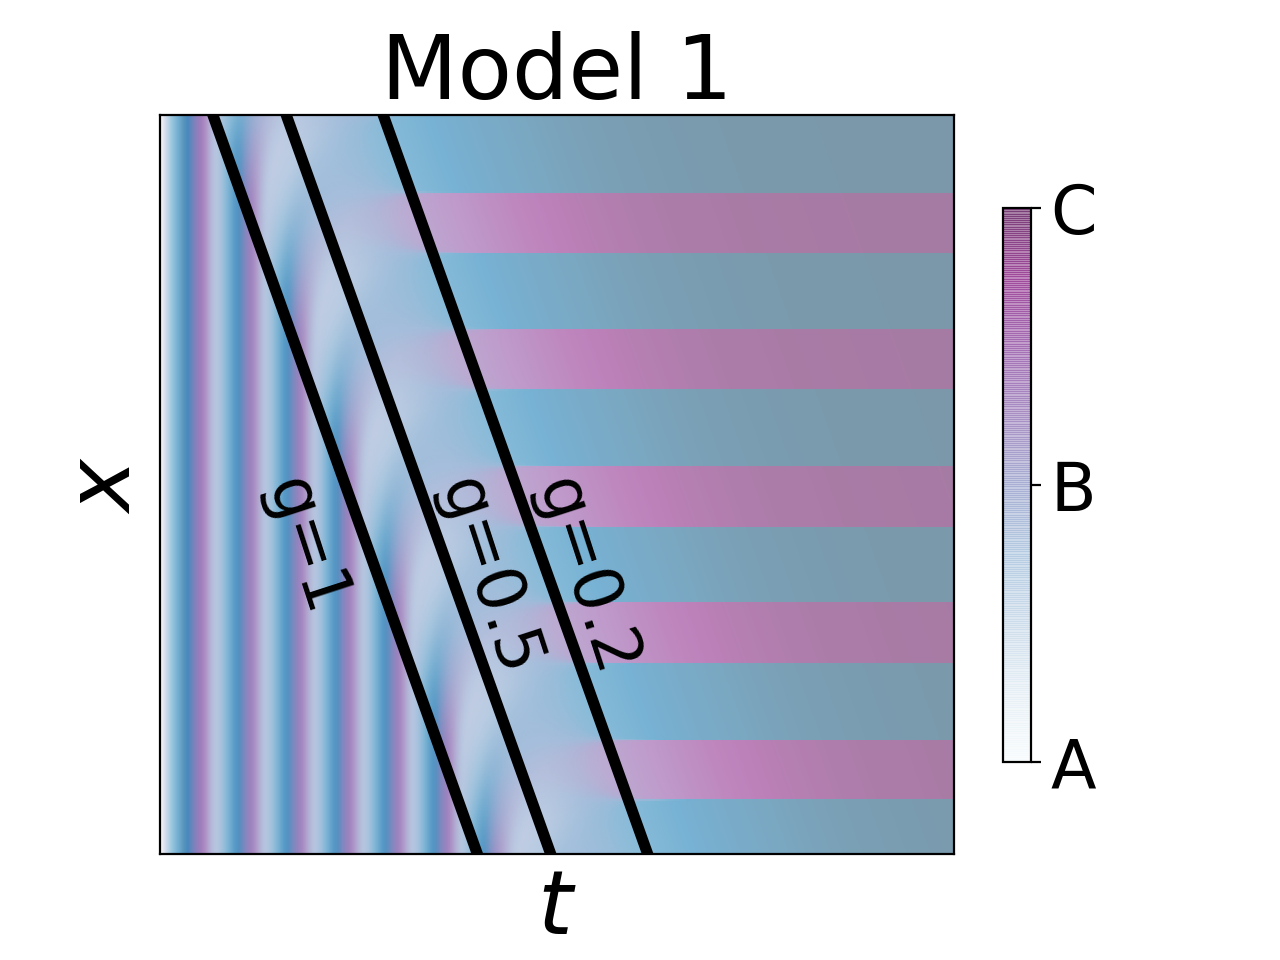

<IPython.core.display.Javascript object>


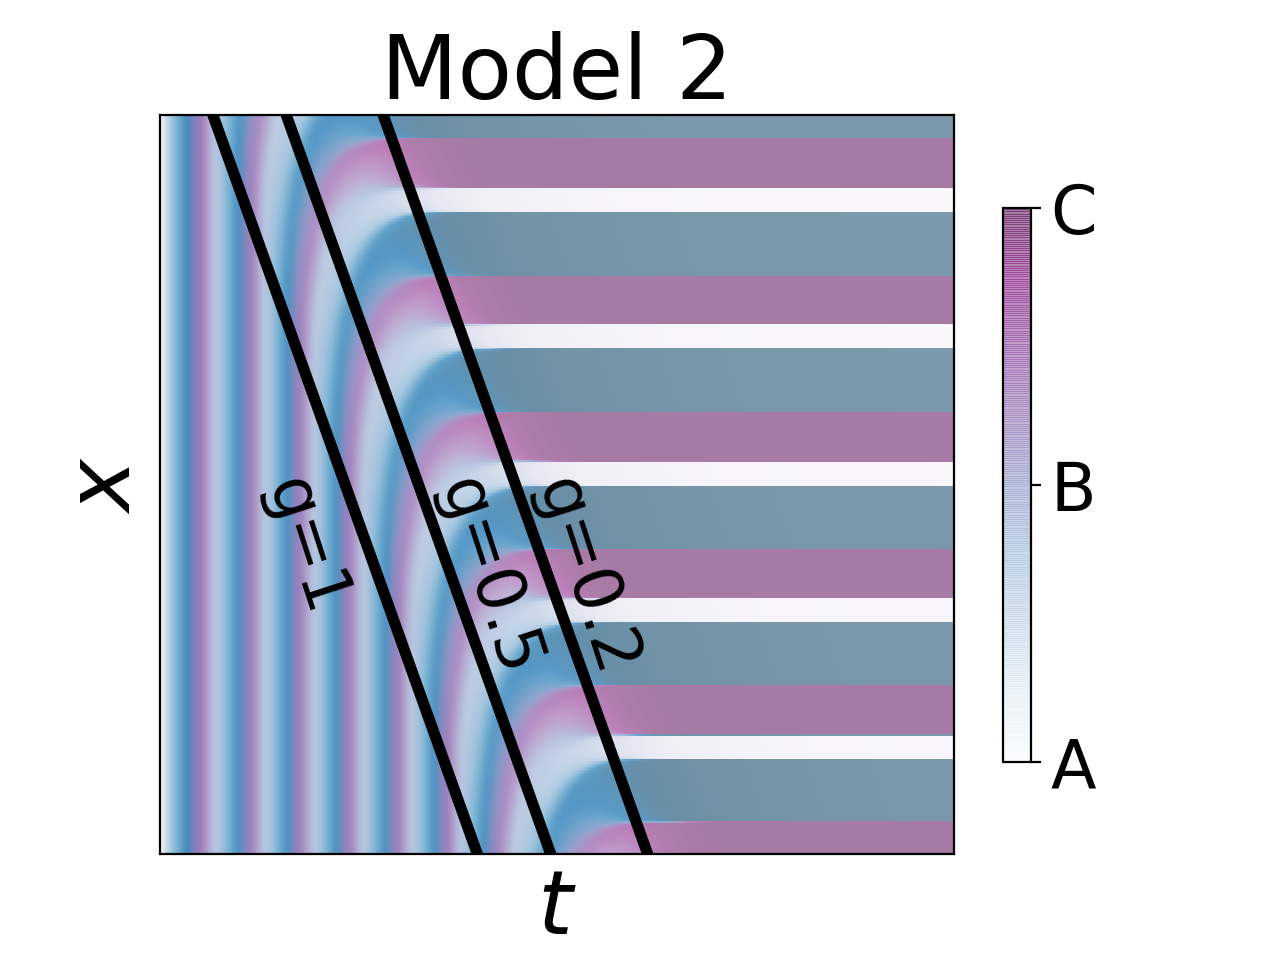

In [14]:
param["s"] = 2.5

plot_g_gradient(g_gradient_asym3_steep_m1, times_plot_asym3_steep_m1, param)
plot_kymograph(results_asym3_steep_m1, g_gradient_asym3_steep_m1, times_plot_asym3_steep_m1, 'Model 1', param)
plot_kymograph(results_asym3_steep_m2, g_gradient_asym3_steep_m2, times_plot_asym3_steep_m2, 'Model 2', param)

<IPython.core.display.Javascript object>


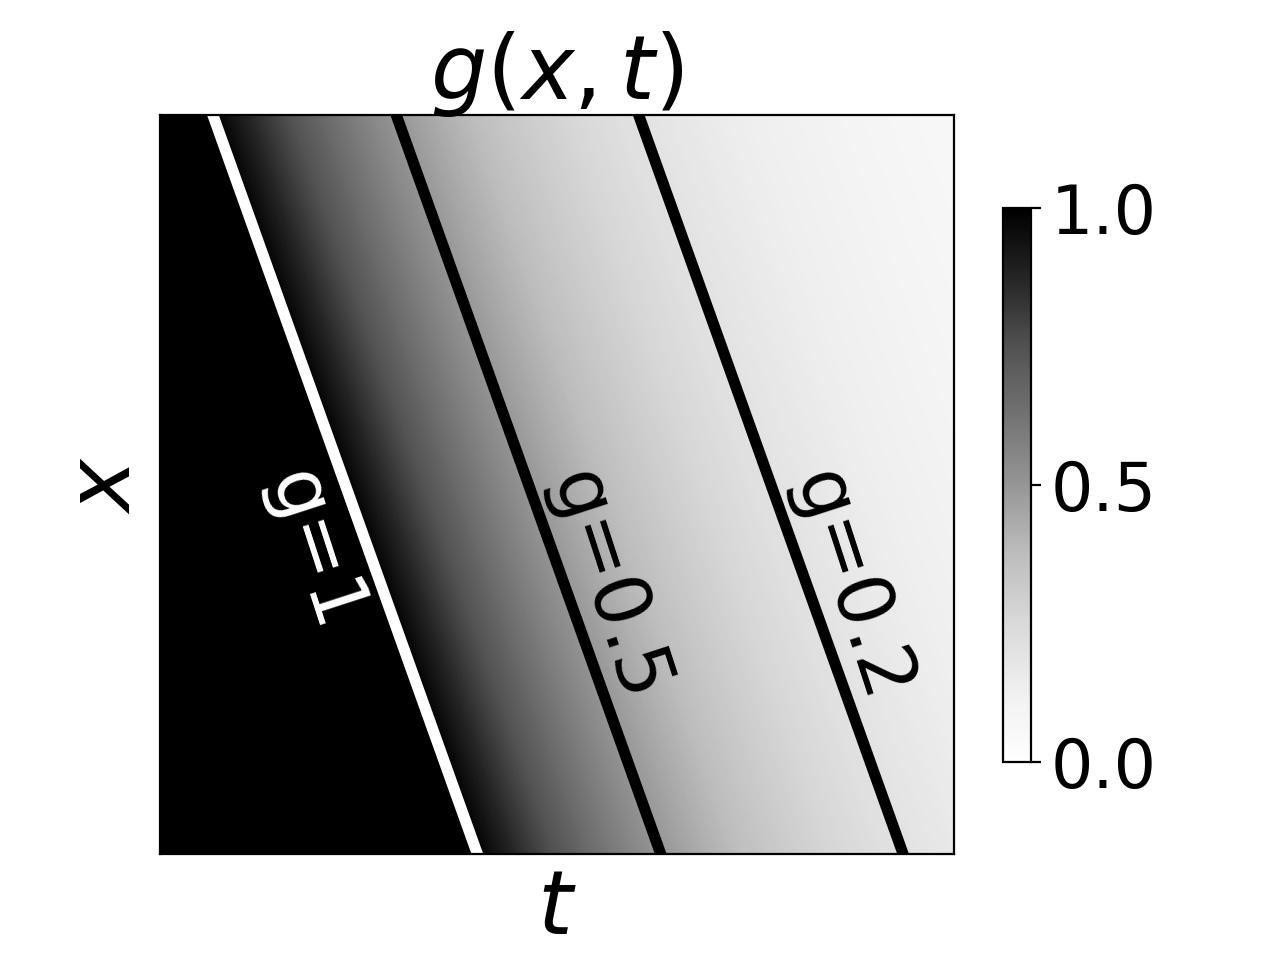

<IPython.core.display.Javascript object>


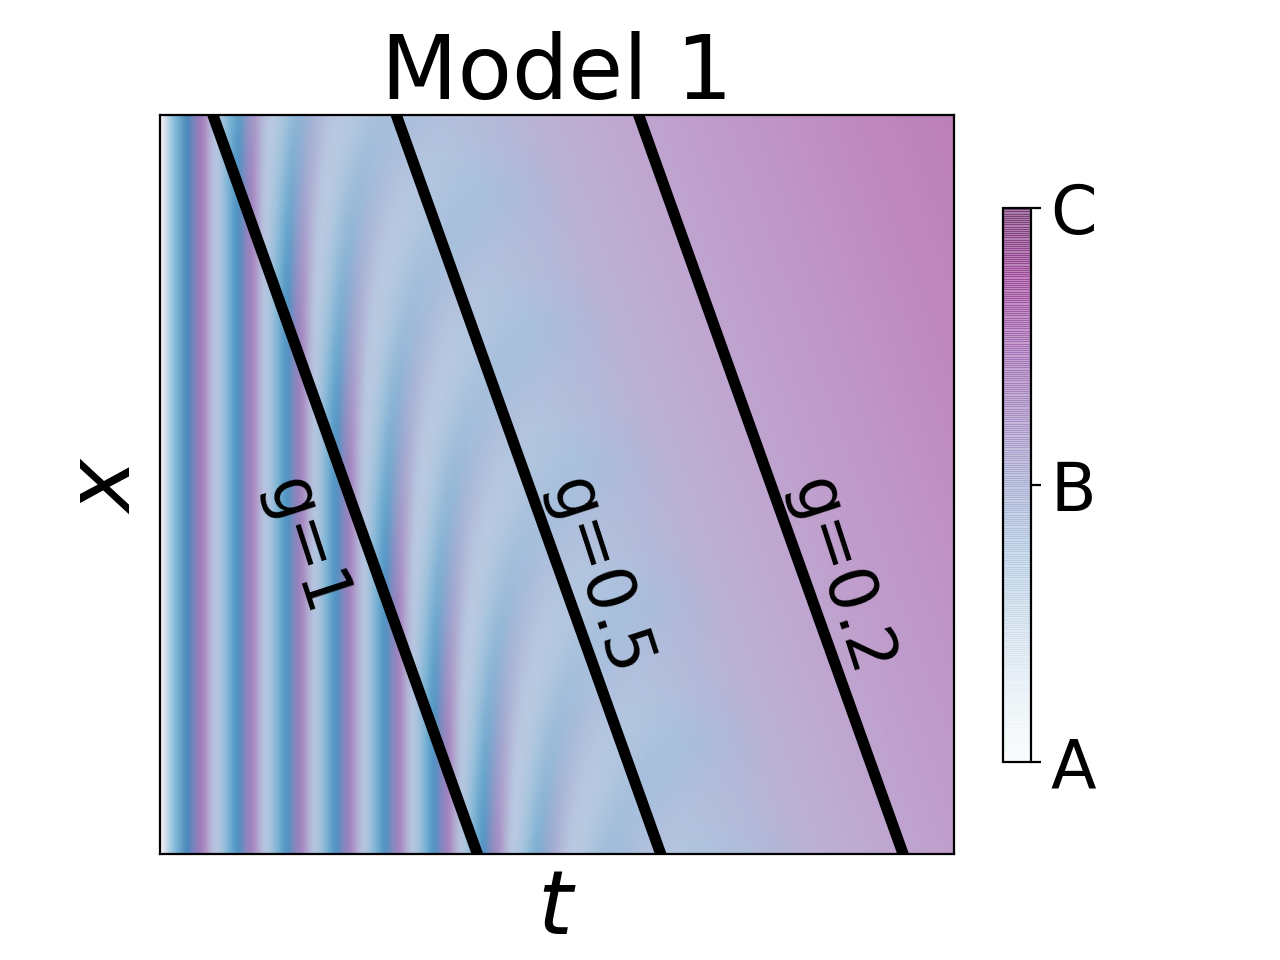

<IPython.core.display.Javascript object>


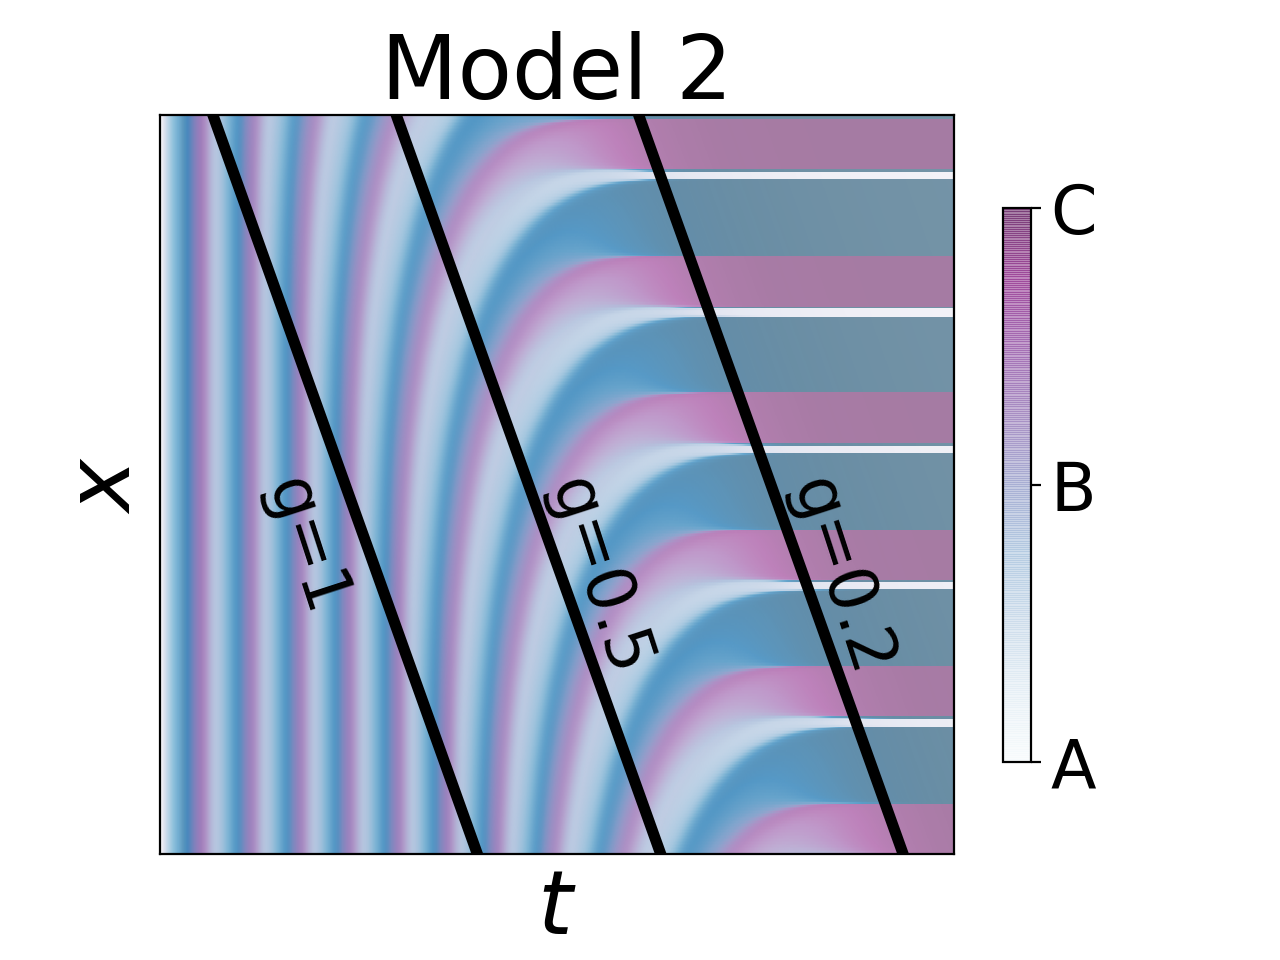

In [15]:
param["s"] = 1.

plot_g_gradient(g_gradient_asym3_shallow_m1, times_plot_asym3_shallow_m1, param)
plot_kymograph(results_asym3_shallow_m1, g_gradient_asym3_shallow_m1, times_plot_asym3_shallow_m1, 'Model 1', param)
plot_kymograph(results_asym3_shallow_m2, g_gradient_asym3_shallow_m2, times_plot_asym3_shallow_m2, 'Model 2', param)

####    

**2. Bifurcation diagrams**

For every asymmetric 3-gene model simulated above, we generate a bifurcation diagram that shows the position (in gene expression space) of the fixed points and limit cycles as a function of parameter $g$. We plot the concentration of gene $A$ at which stable and unstable fixed points can be found, as well as the minimum and maximum concentrations of gene $A$ that are reached by the oscillations on the limit cycle. The XPP AUTO software was used to generate the data plotted on these bifurcation diagams. The `.dat` data files, as well as the `.ode` files used to generate the data can be found in the `XPPAUTO_data` folder.


####   

**2.1 Extracting the fixed points and limit cycles**

We first define functions that extract the data obtained with the XPP AUTO software. The function `extract_fixed_pts` outputs a matrix containing information about the position of the fixed points in the data file and an array of colors for the fixed points, either green for a stable fixed point or red for an unstable fixed point. Similarly, the function `extract_limit_cycles` assigns a color to each limit cycle in the data file, either grey for a stable cycle or blue for an unstable cycle.

In [16]:
def extract_fixed_pts(data_file):
    
    fixed_pts = np.genfromtxt(data_file, delimiter=' ')

    fixed_pts_color = []
    for fps in fixed_pts[:,0]:
    
        if (int(fps) == 1):    fixed_pts_color.append('tab:green')
        elif (int(fps) == 2):    fixed_pts_color.append('tab:red')
        else:
            print('ERROR: one of the points is neither a stable nor unstable equilibria.')
            break
            
    return fixed_pts, fixed_pts_color

        

def extract_limit_cycles(data_file):
    
    limit_cycles = np.genfromtxt(data_file, delimiter=' ')

    limit_cycles_color = []
    for lc in limit_cycles[:,0]:
    
        if (int(lc) == 3):    limit_cycles_color.append('k')
        elif (int(lc) == 4):    limit_cycles_color.append('tab:blue')
        else:
            print('ERROR: one of the points is neither stable nor unstable periodics.')
            break
            
    return limit_cycles, limit_cycles_color

####   

**2.2 Generating the bifurcation diagrams**

We plot the bifurcation diagrams, and indicate the bifurcation events that occur in each model.


####      

**2.2.1 Weak asymmetry**

We first generate the bifurcation diagrams for the 3-gene Models 1 and 2 with the simple asymmetry.

<IPython.core.display.Javascript object>


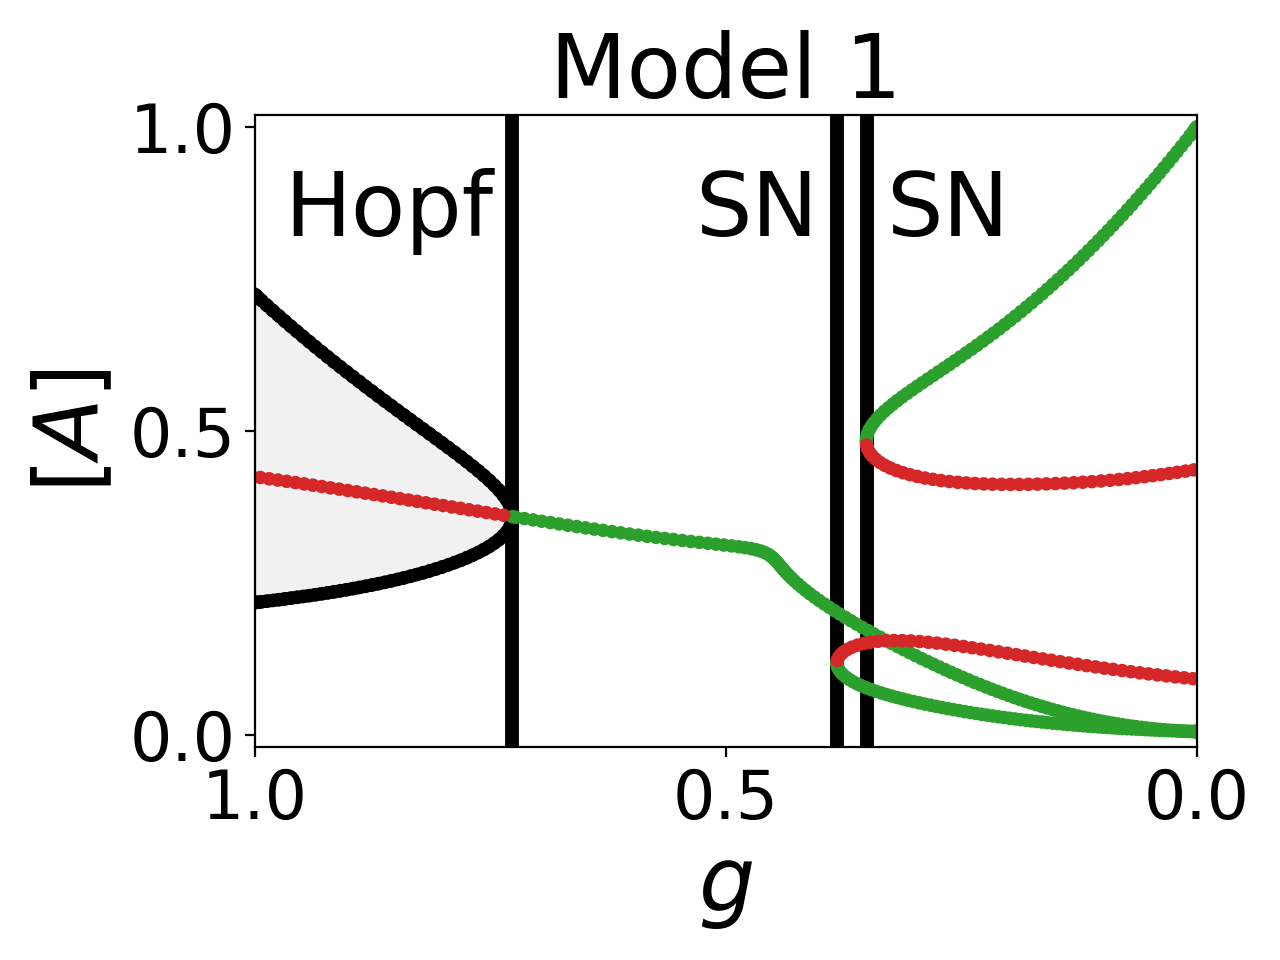

In [17]:
# Model 1

# Extract the data
fp_asym1_m1, fp_asym1_m1_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_asym1_m1_fp.dat')
lc_asym1_m1, lc_asym1_m1_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_asym1_m1_lc.dat')
g_Hopf = 0.7265
g_SN1 = 0.382
g_SN2 = 0.35

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym1_m1[:50,3], lc_asym1_m1[:50,9], lc_asym1_m1[:50,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym1_m1[:,3], lc_asym1_m1[:,6], s=15, color=lc_asym1_m1_color)
ax.scatter(lc_asym1_m1[:,3], lc_asym1_m1[:,9], s=15, color=lc_asym1_m1_color)

# Fixed points
ax.scatter(fp_asym1_m1[:,3], fp_asym1_m1[:,6], s=15, color=fp_asym1_m1_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.82, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN1, g_SN1], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
ax.plot([g_SN2, g_SN2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN2-0.02, 0.82, 'SN', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


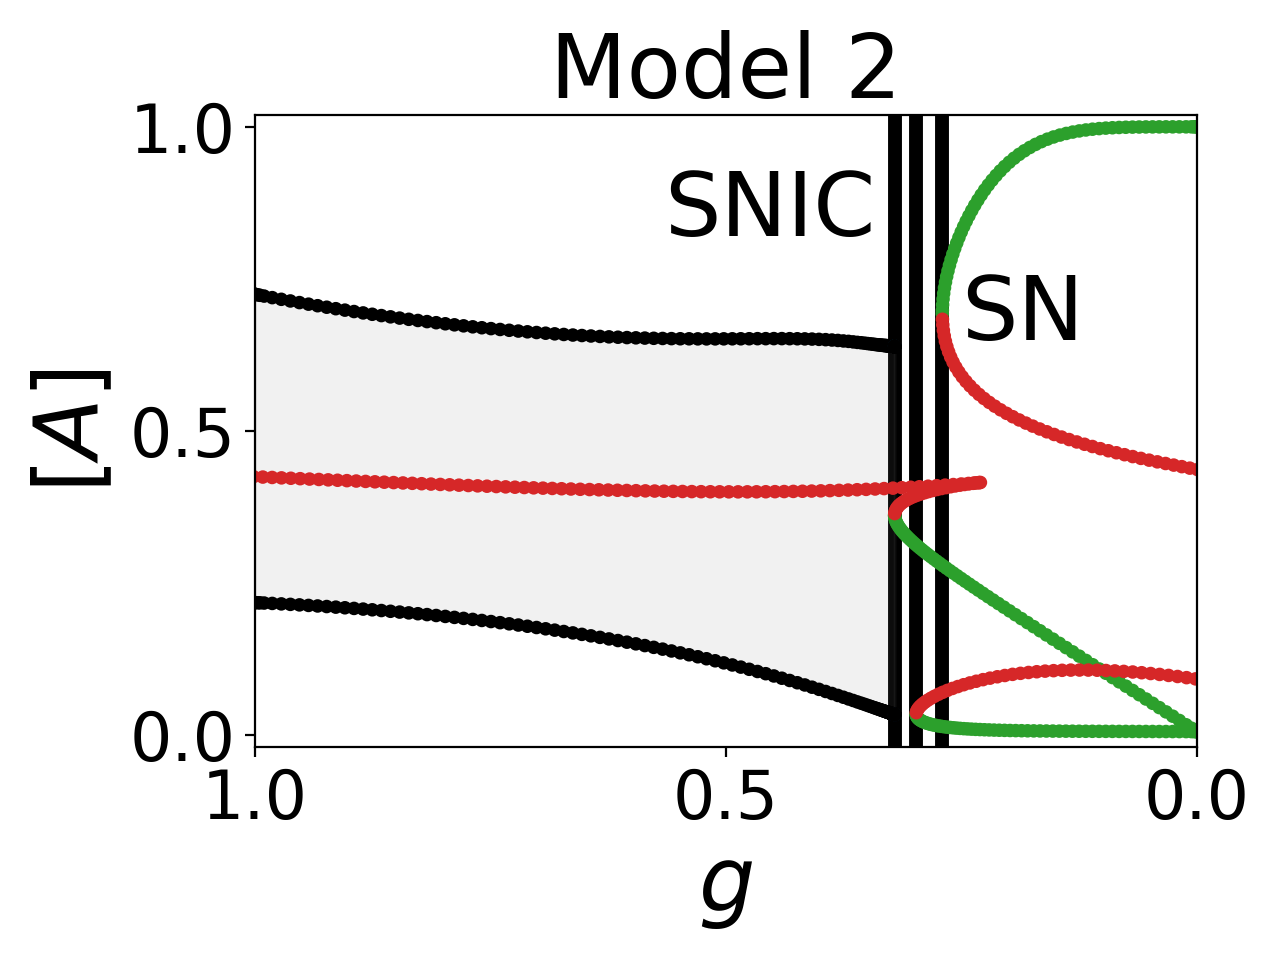

In [18]:
# Model 2

# Extract the data
fp_asym1_m2, fp_asym1_m2_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_asym1_m2_fp.dat')
lc_asym1_m2, lc_asym1_m2_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_asym1_m2_lc.dat')
g_SNIC = 0.3207
g_SN1 = 0.298
g_SN2 = 0.27

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym1_m2[:,3], lc_asym1_m2[:,9], lc_asym1_m2[:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym1_m2[:,3], lc_asym1_m2[:,6], s=15, color=lc_asym1_m2_color)
ax.scatter(lc_asym1_m2[:,3], lc_asym1_m2[:,9], s=15, color=lc_asym1_m2_color)

# Fixed points
ax.scatter(fp_asym1_m2[:,3], fp_asym1_m2[:,6], s=15, color=fp_asym1_m2_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.82, 'SNIC', fontsize=32, horizontalalignment='right')
ax.plot([g_SN1, g_SN1], [-0.02, 1.02], 'k', lw=5, zorder=0)
# ax.text(g_SN1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
ax.plot([g_SN2, g_SN2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN2-0.02, 0.65, 'SN', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

####      

**2.2.2 Strong asymmetry**

Bifurcation diagrams for the 3-gene Models 1 and 2 with the strong asymmetry.

<IPython.core.display.Javascript object>


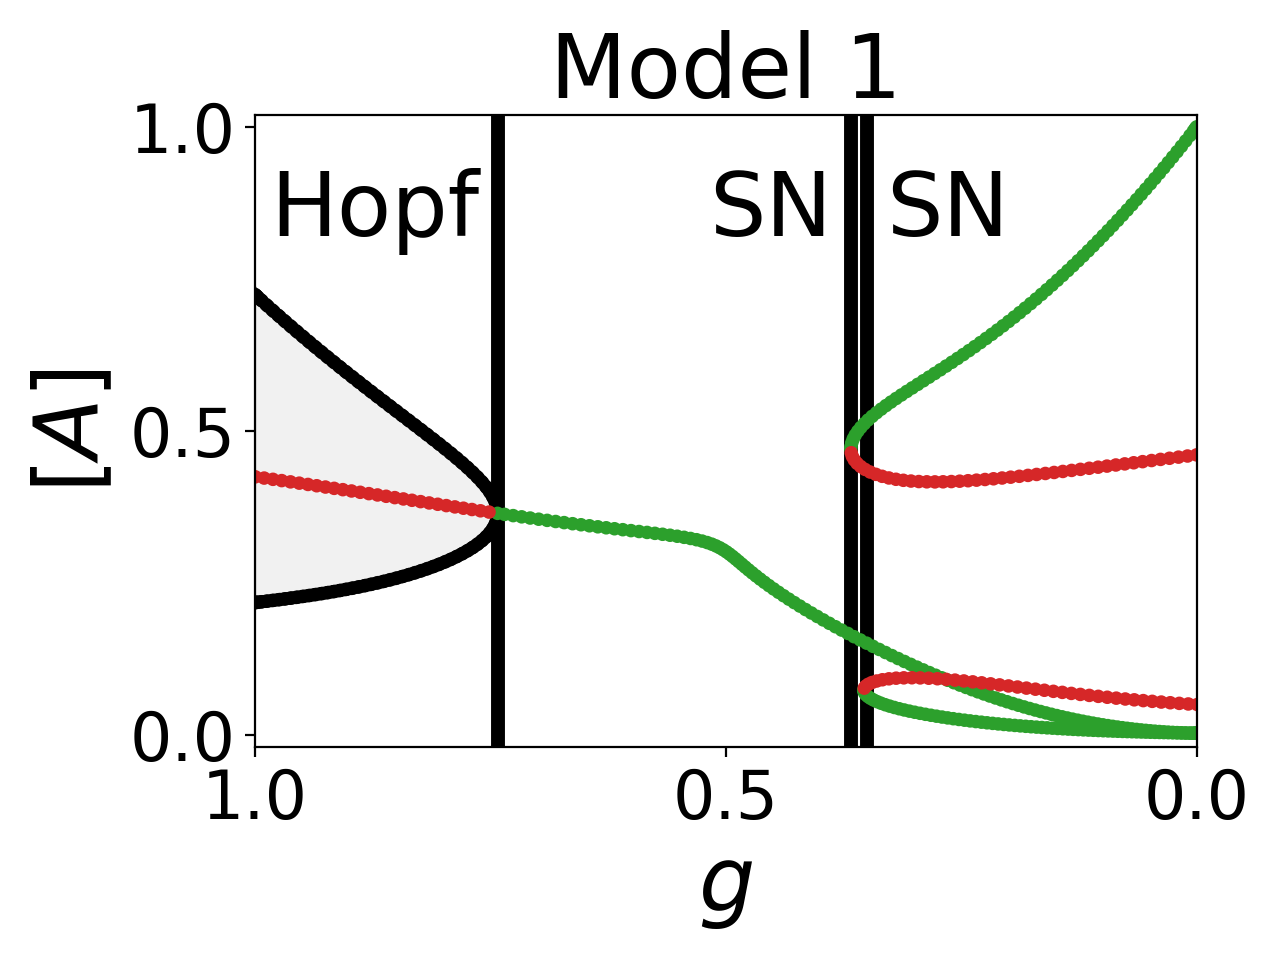

In [19]:
# Model 1

# Extract the data
fp_asym2_m1, fp_asym2_m1_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_asym2_m1_fp.dat')
lc_asym2_m1, lc_asym2_m1_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_asym2_m1_lc.dat')
g_Hopf = 0.742
g_SN1 = 0.367
g_SN2 = 0.35

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym2_m1[:50,3], lc_asym2_m1[:50,9], lc_asym2_m1[:50,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym2_m1[:,3], lc_asym2_m1[:,6], s=15, color=lc_asym2_m1_color)
ax.scatter(lc_asym2_m1[:,3], lc_asym2_m1[:,9], s=15, color=lc_asym2_m1_color)

# Fixed points
ax.scatter(fp_asym2_m1[:,3], fp_asym2_m1[:,6], s=15, color=fp_asym2_m1_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.82, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN1, g_SN1], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
ax.plot([g_SN2, g_SN2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN2-0.02, 0.82, 'SN', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


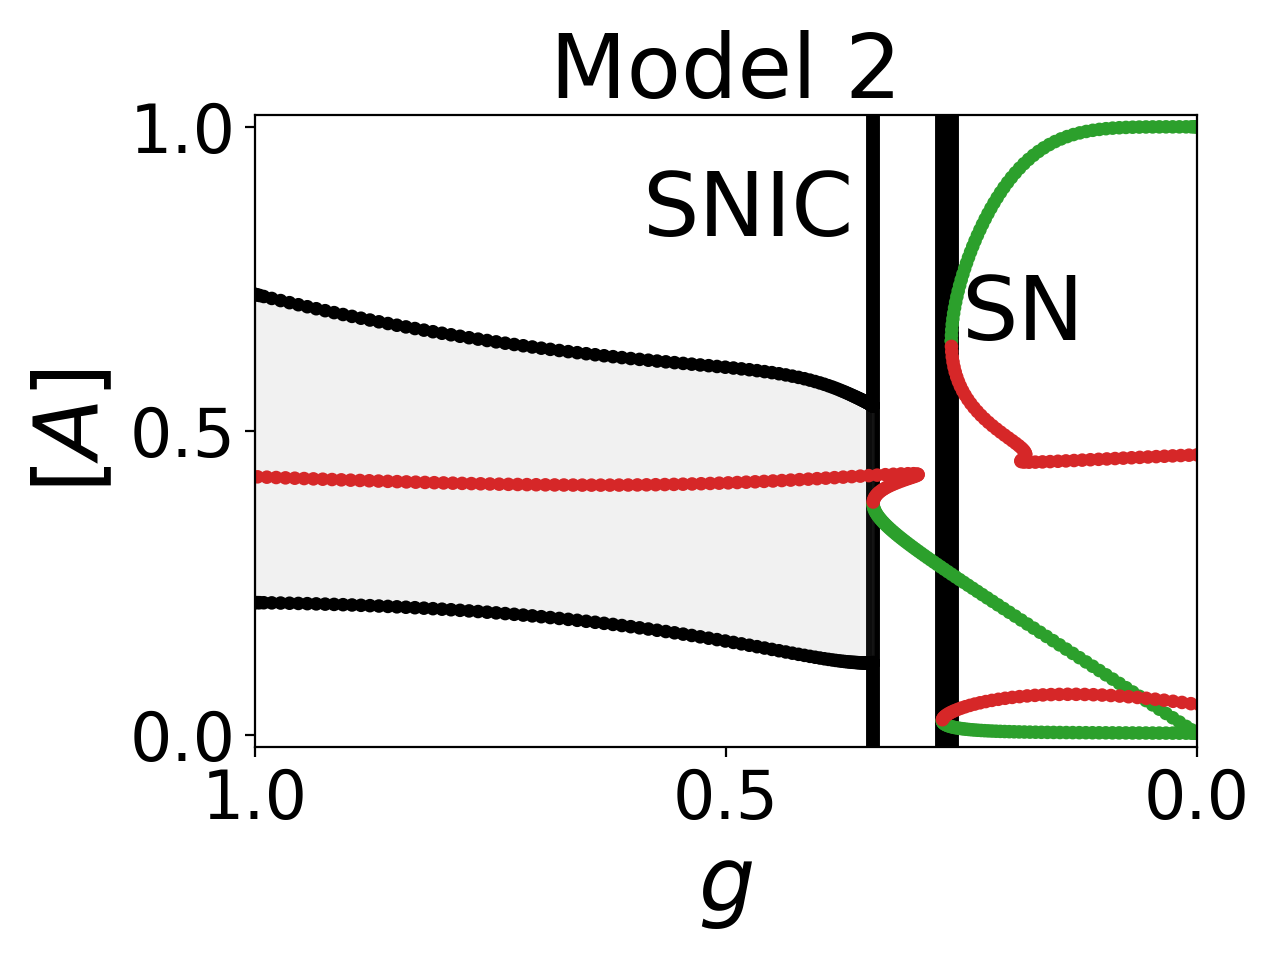

In [20]:
# Model 2

# Extract the data
fp_asym2_m2, fp_asym2_m2_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_asym2_m2_fp.dat')
lc_asym2_m2, lc_asym2_m2_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_asym2_m2_lc.dat')
g_SNIC = 0.344
g_SN1 = 0.26
g_SN2 = 0.27

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym2_m2[:,3], lc_asym2_m2[:,9], lc_asym2_m2[:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym2_m2[:,3], lc_asym2_m2[:,6], s=15, color=lc_asym2_m2_color)
ax.scatter(lc_asym2_m2[:,3], lc_asym2_m2[:,9], s=15, color=lc_asym2_m2_color)

# Fixed points
ax.scatter(fp_asym2_m2[:,3], fp_asym2_m2[:,6], s=15, color=fp_asym2_m2_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.82, 'SNIC', fontsize=32, horizontalalignment='right')
ax.plot([g_SN1, g_SN1], [-0.02, 1.02], 'k', lw=5, zorder=0)
# ax.text(g_SN1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
ax.plot([g_SN2, g_SN2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN2-0.02, 0.65, 'SN', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

####      

**2.2.3 Random asymmetry**

Bifurcation diagrams for the 3-gene Models 1 and 2 with the random asymmetry.

<IPython.core.display.Javascript object>


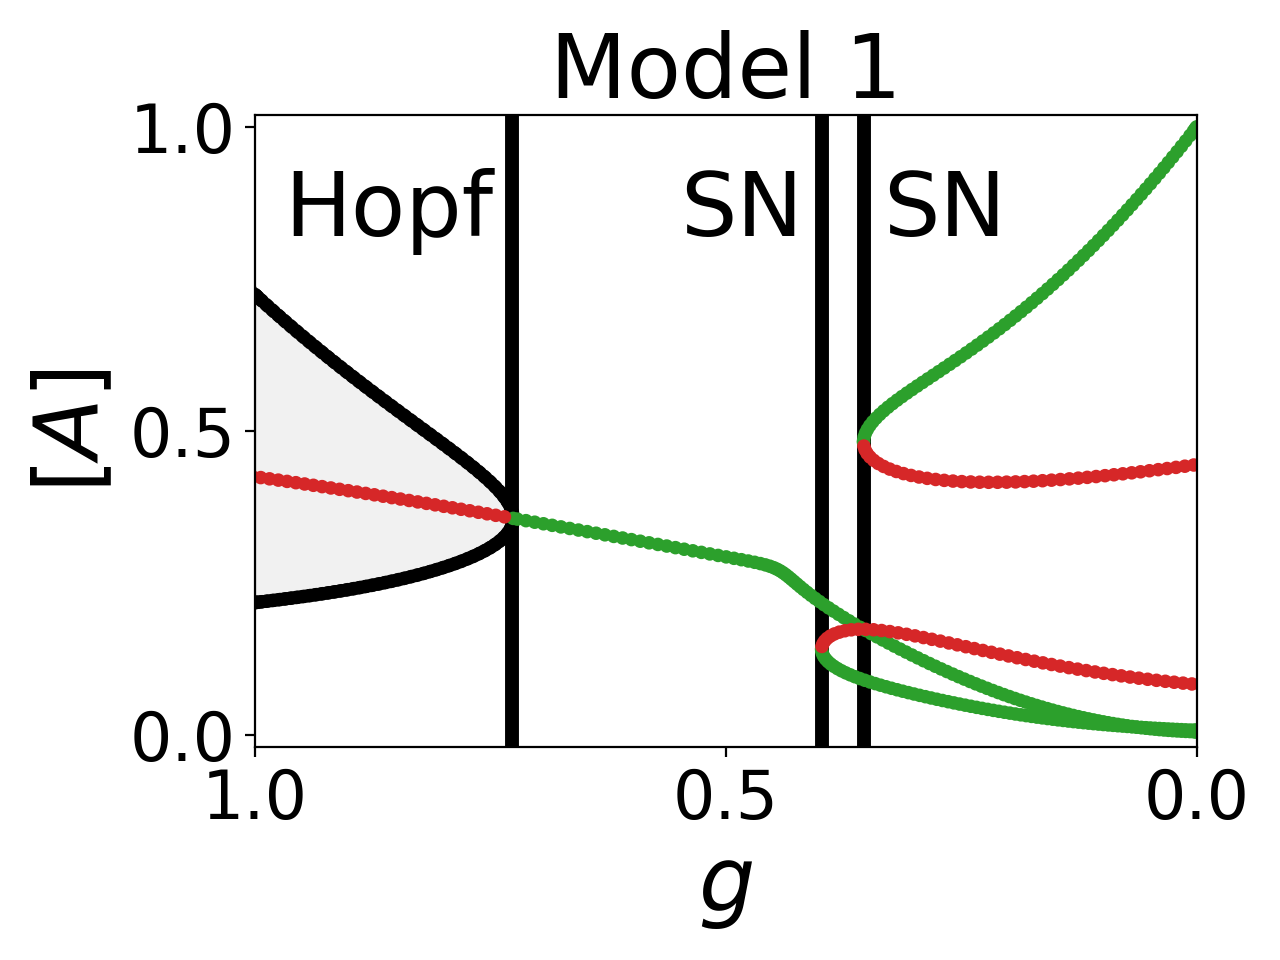

In [21]:
# Model 1

# Extract the data
fp_asym3_m1, fp_asym3_m1_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_asym3_m1_fp.dat')
lc_asym3_m1, lc_asym3_m1_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_asym3_m1_lc.dat')
g_Hopf = 0.7265
g_SN1 = 0.398
g_SN2 = 0.353

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym3_m1[:50,3], lc_asym3_m1[:50,9], lc_asym3_m1[:50,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym3_m1[:,3], lc_asym3_m1[:,6], s=15, color=lc_asym3_m1_color)
ax.scatter(lc_asym3_m1[:,3], lc_asym3_m1[:,9], s=15, color=lc_asym3_m1_color)

# Fixed points
ax.scatter(fp_asym3_m1[:,3], fp_asym3_m1[:,6], s=15, color=fp_asym3_m1_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.82, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN1, g_SN1], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
ax.plot([g_SN2, g_SN2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN2-0.02, 0.82, 'SN', fontsize=32, horizontalalignment='left')
   
# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


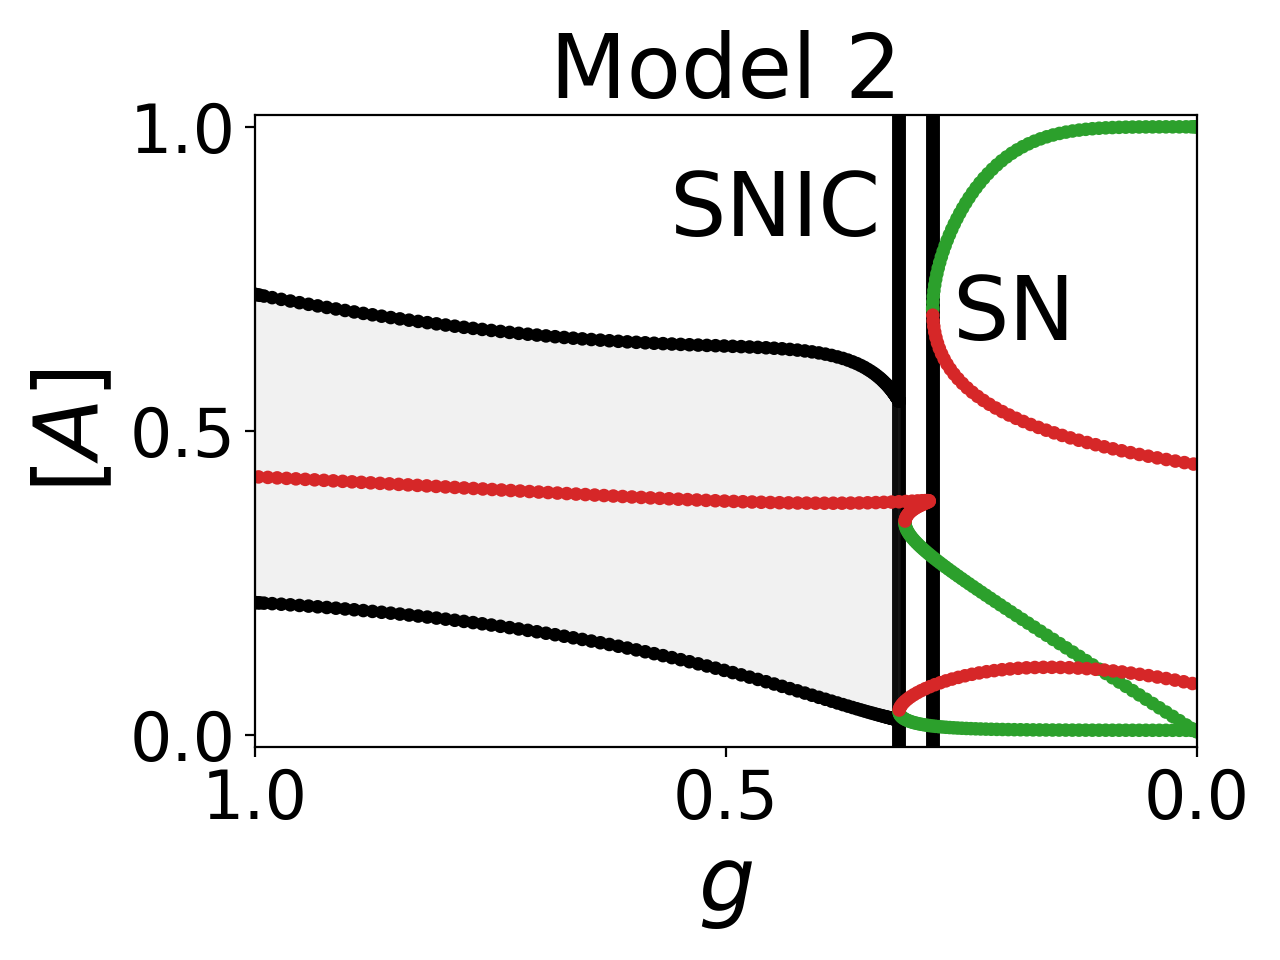

In [22]:
# Model 2

fp_asym3_m2, fp_asym3_m2_color = extract_fixed_pts('XPPAUTO_data/3-gene_models/3-gene_asym3_m2_fp.dat')
lc_asym3_m2, lc_asym3_m2_color = extract_limit_cycles('XPPAUTO_data/3-gene_models/3-gene_asym3_m2_lc.dat')
g_SNIC = 0.316
g_SN1 = 0.31
g_SN2 = 0.28

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_asym3_m2[:,3], lc_asym3_m2[:,9], lc_asym3_m2[:,6], color='tab:grey', alpha=0.1)
ax.scatter(lc_asym3_m2[:,3], lc_asym3_m2[:,6], s=15, color=lc_asym3_m2_color)
ax.scatter(lc_asym3_m2[:,3], lc_asym3_m2[:,9], s=15, color=lc_asym3_m2_color)

# Fixed points
ax.scatter(fp_asym3_m2[:,3], fp_asym3_m2[:,6], s=15, color=fp_asym3_m2_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.82, 'SNIC', fontsize=32, horizontalalignment='right')
# ax.plot([g_SN1, g_SN1], [-0.02, 1.02], 'k', lw=5, zorder=0)
# ax.text(g_SN1+0.02, 0.82, 'SN', fontsize=32, horizontalalignment='right')
ax.plot([g_SN2, g_SN2], [-0.02, 1.02], 'k', lw=5, zorder=0)
ax.text(g_SN2-0.02, 0.65, 'SN', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$[A]$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-0.02, 1.02])
ax.set_xticks([1., 0.5, 0.])
ax.set_yticks([0., 0.5, 1.])
        
fig.tight_layout()
fig.show()

####    

**3. Mutual information**

We now plot the mutual information between the phase along the cycle of genetic oscillations at the beginning of the simulation and the region of the pattern at the end of the simulation. See the Methods and the Supplement for more details.

We first define a function that extracts the data before making the graph. The data is obtained with other python codes that are included in the `Mutual_info_data` folder. We do not include the codes directly in this notebook, since running them can take several hours. In short, we set all cells in the same initial state at the begining of the simulation, i.e. at the same phase of the genetic oscillations. The probability of being in a given region of the pattern is calculated by computing the relative concentration of all genes at the end of the simulation. We repeat this procedure for different initial phases. Since the elongation speed is constant, we sample the initial phases uniformly on the cycle.

We compute and plot the mutual information for multiple values of the steepness of the morphogen gradient. Note that the ideal mutual information is obtained by using a step function for $g$, jumping from 1 to 0. Indeed, using such a function for $g$ enforces the system to switch directly from the dynamic module to the static module. This allows us to measure the information content encoded in the static module. Note that the ideal mutual information is not $\log(3)$ bits since the regions of the pattern are asymmetric.


####   

**3.1 Extracting the mutual information data**

In the next code cell, we define a function that extracts the data of the mutual information from the `.txt` files found in the `Mutual_info_data` folder. Each file has the mutual information for a given version of the model (Model 1 or Model 2) and for one specific asymmetry. The weak, strong and random asymmetries are called `asym1`, `asym2` and `asym3`, respectively. Therefore, we need to specify the asymmetry and the model used to generate the data, via parameters `asym_index` and `m_index`, respectively.

In [23]:
def extract_mutual_info(asym_index, m_index):
    
    mutual_info = np.genfromtxt("Mutual_info_data/3-gene_models/3-gene_asym"
                                +str(asym_index)+"_m"
                                +str(m_index)+"_MI.txt", delimiter=",")
    
    return mutual_info.transpose()

####   

**3.2 Generating the mutual information plots**

We plot the mutual information as a function of the morphogen gradient steepness for both models. We generate one plot per asymmetry type.


####      

**3.2.1 Weak asymmetry**

Mutual information for the 3-gene Models 1 and 2 with the weak asymmetry.

<IPython.core.display.Javascript object>


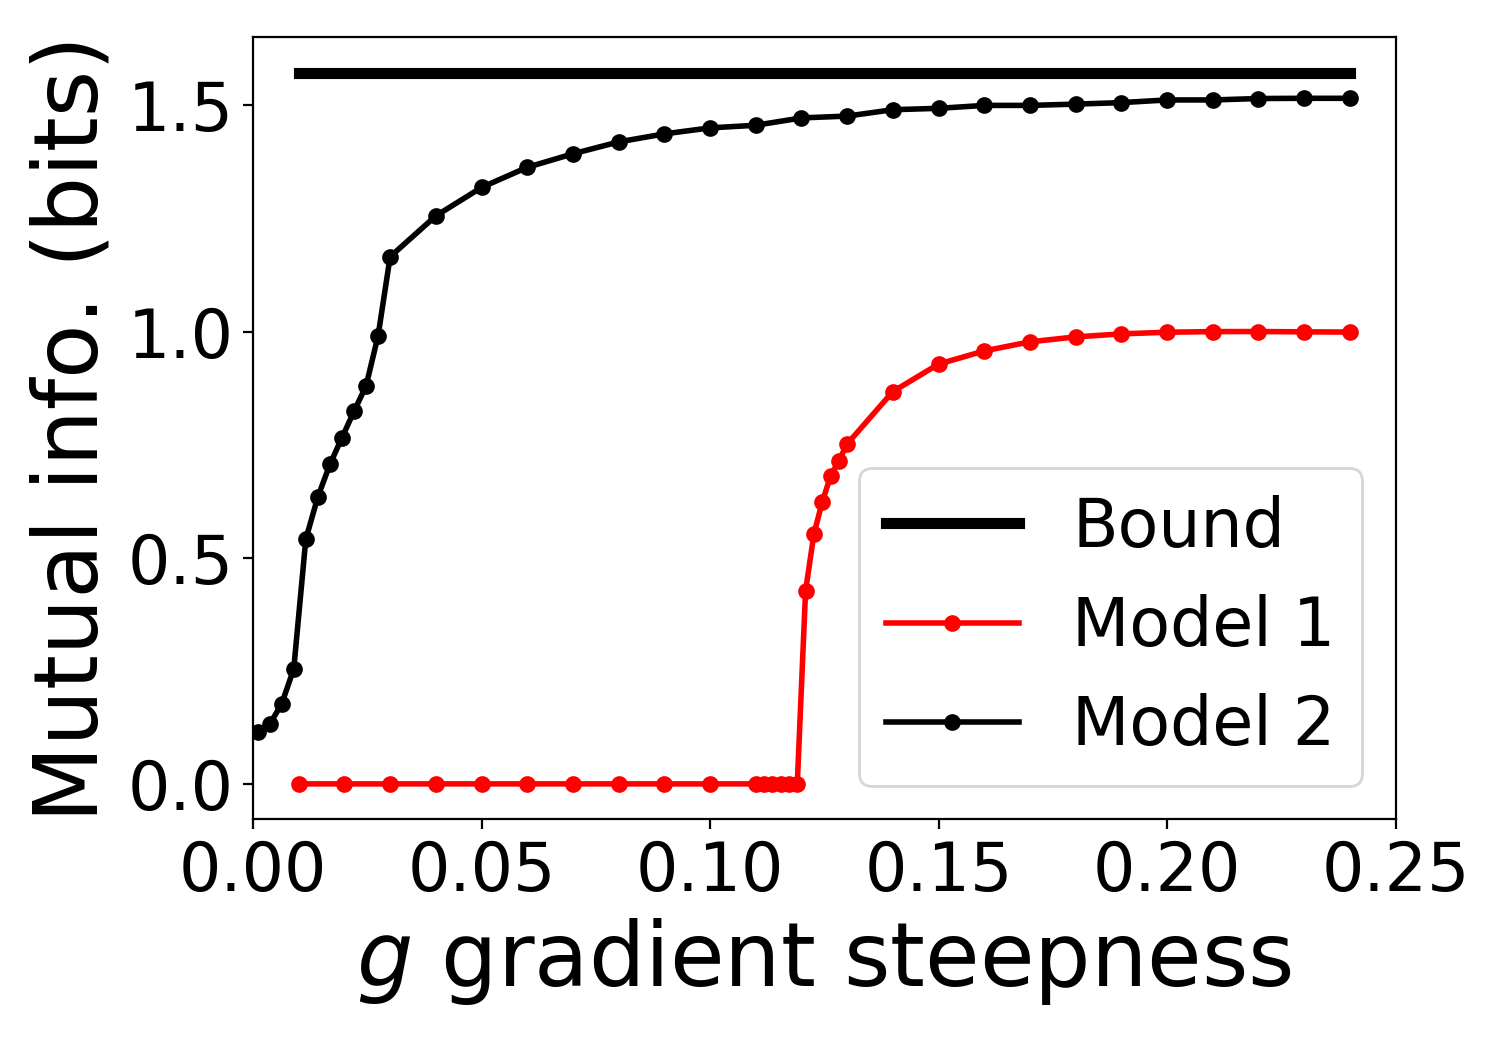

In [24]:
# Retrieve M.I. data
MI_asym1_m1  = extract_mutual_info(1, 1)
MI_asym1_m2 = extract_mutual_info(1, 2)


# Generate the plot
plt.rcParams["figure.figsize"] = 7.5, 5.2
fig, ax = plt.subplots()

# Theoretical upper bound
ax.plot([min(MI_asym1_m1[0,1:]), max(MI_asym1_m1[0,1:])], [MI_asym1_m1[1,0], MI_asym1_m1[1,0]], c='k', ls='-', lw=4, label='Bound')

# Model 1
ax.plot(MI_asym1_m1[0,1:], MI_asym1_m1[1,1:], color='r', marker='o', markersize=5, lw=2, label='Model 1')

# Model 2
ax.plot(MI_asym1_m2[0,1:], MI_asym1_m2[1,1:], color='k', marker='o', markersize=5, lw=2, label='Model 2')

# Other plot options
ax.set_xlabel('$g$ gradient steepness', fontsize=32)
ax.set_ylabel('Mutual info. (bits)', fontsize=32)
ax.set_xlim([0., .25])
ax.tick_params(labelsize=24)
ax.legend(loc=4, fontsize=24)

fig.tight_layout()
fig.show()

####      

**3.2.2 Strong asymmetry**

Mutual information for the 3-gene Models 1 and 2 with the strong asymmetry.

<IPython.core.display.Javascript object>


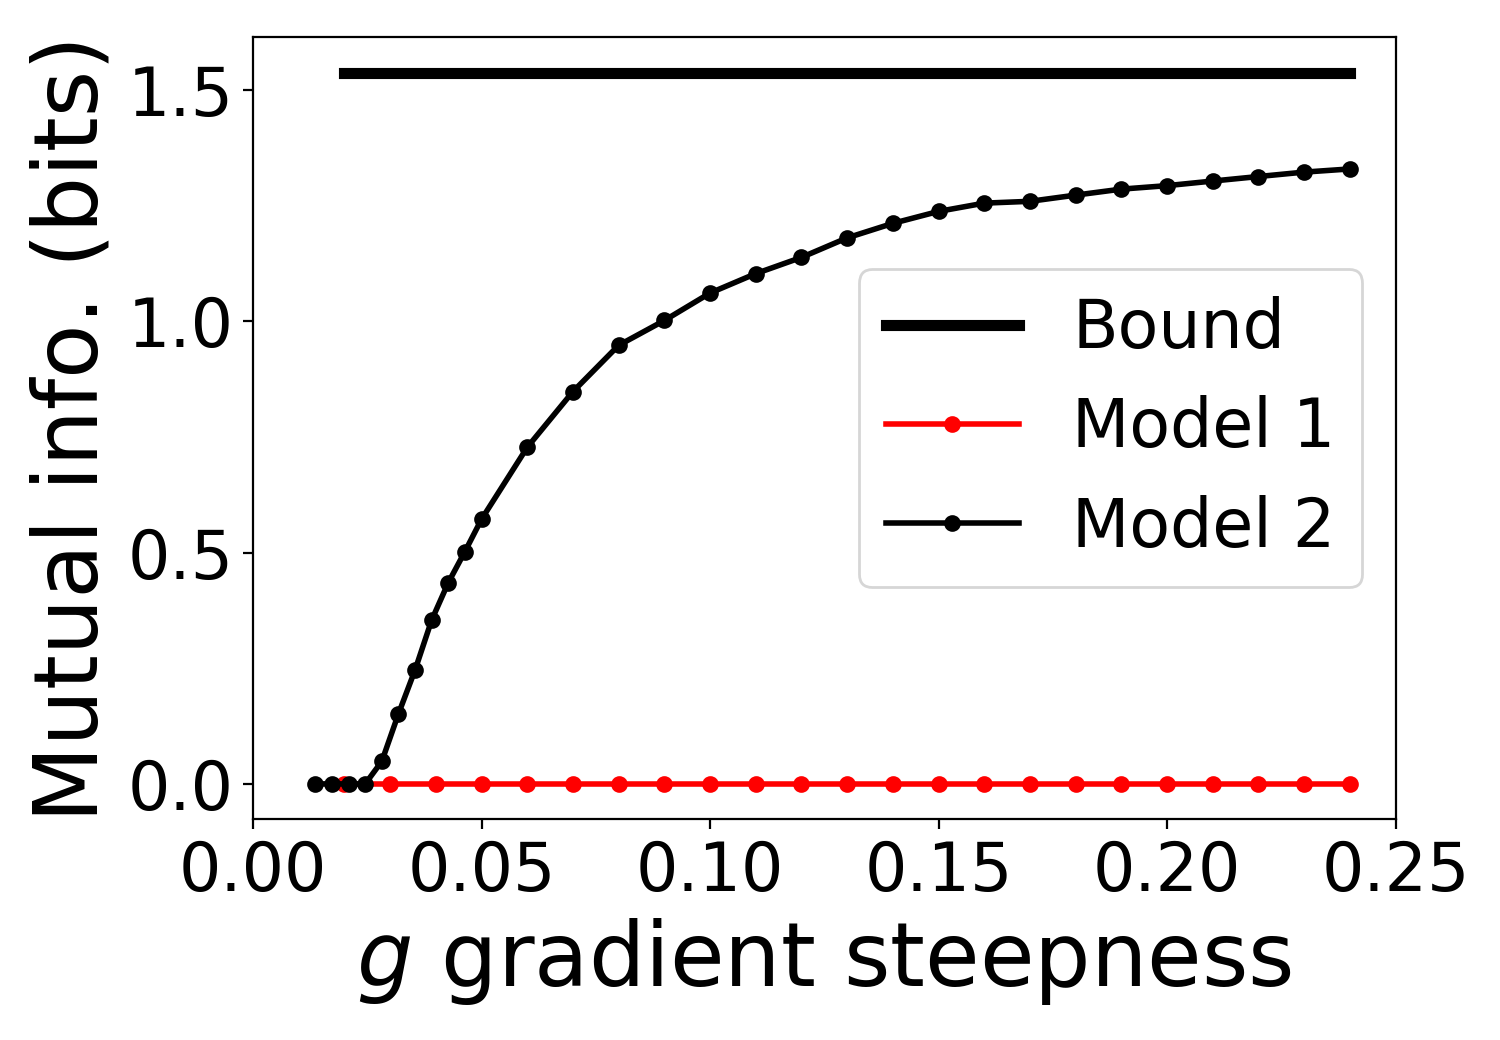

In [25]:
# Retrieve M.I. data
MI_asym2_m1  = extract_mutual_info(2, 1)
MI_asym2_m2 = extract_mutual_info(2, 2)


# Generate the plot
plt.rcParams["figure.figsize"] = 7.5, 5.2
fig, ax = plt.subplots()

# Theoretical upper bound
ax.plot([min(MI_asym2_m1[0,1:]), max(MI_asym2_m1[0,1:])], [MI_asym2_m1[1,0], MI_asym2_m1[1,0]], c='k', ls='-', lw=4, label='Bound')

# Model 1
ax.plot(MI_asym2_m1[0,1:], MI_asym2_m1[1,1:], color='r', marker='o', markersize=5, lw=2, label='Model 1')

# Model 2
ax.plot(MI_asym2_m2[0,1:], MI_asym2_m2[1,1:], color='k', marker='o', markersize=5, lw=2, label='Model 2')

# Other plot options
ax.set_xlabel('$g$ gradient steepness', fontsize=32)
ax.set_ylabel('Mutual info. (bits)', fontsize=32)
ax.set_xlim([0., .25])
ax.tick_params(labelsize=24)
ax.legend(loc=5, fontsize=24)

fig.tight_layout()
fig.show()

####      

**3.2.3 Random asymmetry**

Mutual information for the 3-gene Models 1 and 2 with the random asymmetry.

<IPython.core.display.Javascript object>


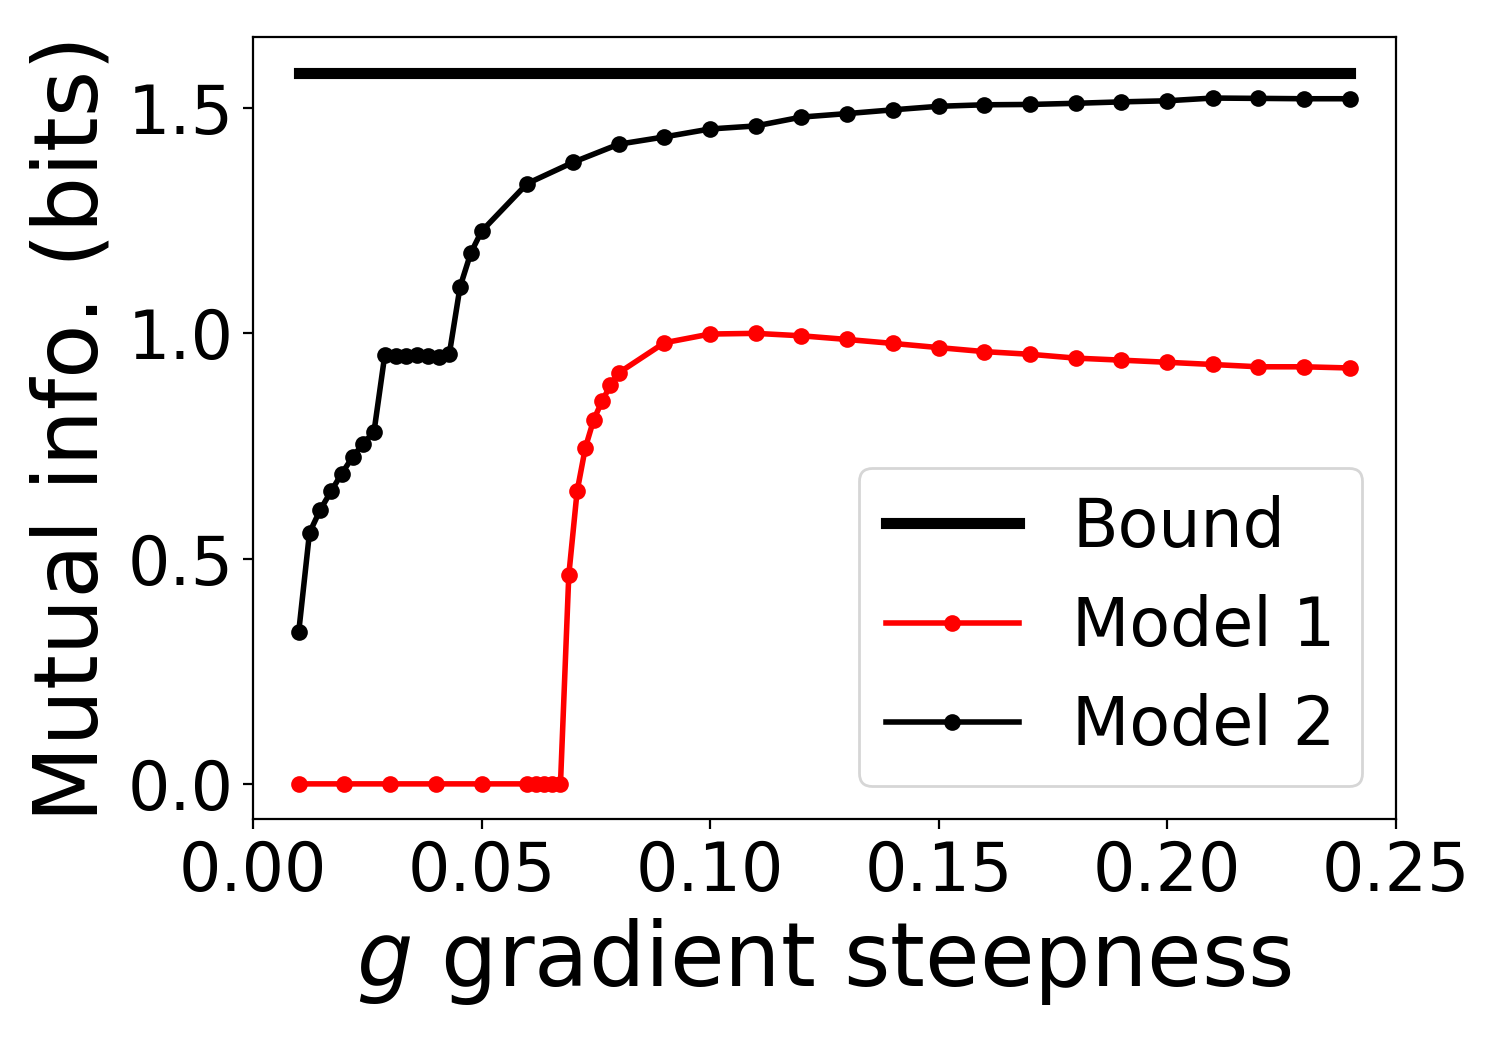

In [26]:
# Retrieve M.I. data
MI_asym3_m1  = extract_mutual_info(3, 1)
MI_asym3_m2 = extract_mutual_info(3, 2)


# Generate the plot
plt.rcParams["figure.figsize"] = 7.5, 5.2
fig, ax = plt.subplots()

# Theoretical upper bound
ax.plot([min(MI_asym3_m1[0,1:]), max(MI_asym3_m1[0,1:])], [MI_asym3_m1[1,0], MI_asym3_m1[1,0]], c='k', ls='-', lw=4, label='Bound')

# Model 1
ax.plot(MI_asym3_m1[0,1:], MI_asym3_m1[1,1:], color='r', marker='o', markersize=5, lw=2, label='Model 1')

# Model 2
ax.plot(MI_asym3_m2[0,1:], MI_asym3_m2[1,1:], color='k', marker='o', markersize=5, lw=2, label='Model 2')

# Other plot options
ax.set_xlabel('$g$ gradient steepness', fontsize=32)
ax.set_ylabel('Mutual info. (bits)', fontsize=32)
ax.set_xlim([0., .25])
ax.tick_params(labelsize=24)
ax.legend(loc=4, fontsize=24)

fig.tight_layout()
fig.show()